In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd

import warnings
warnings.simplefilter(action='ignore') #, category=FutureWarning)

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import proplot as plot
plot.rc.reset()
plot.rc.update({"legend.handlelength": 2})
from mpl_toolkits.basemap import Basemap
import cmaps
import copy
import calendar
from scipy import interpolate

# =============== Import self-defined functions =============== #
# Read Isca dataset
from analysis_functions import (get_ds_arr_from_exps, sigma_to_pressure_level, add_datetime_info,
                                z_to_p, get_unique_line_labels, get_global_mean)

# Read observed dataset
from read_obs_CRE import read_toa_flux_obs, read_surf_flux_obs, read_toa_cre_obs

# Calculate CRE and CWP for Isca dataset
from isca_cre_cwp import calc_toa_cre_for_isca, calc_total_cwp_for_isca, add_toa_net_flux_to_ds_arr

# Figs. 7, 9, 10, 12, 14 Spatial patterns
from plot_spatial_figs import cmp_spatial_patterns_from_exps_and_obs

# Fig. 11 Low cloud improvement
from low_cld_scheme_improvement import low_cloud_improvement_evaluation

# Fig. 13 LW CRE evaluation
from bin_dataset_nd import bin_obs_data, bin_isca_exp_data
from lwcre_improvement_evaluation import cld_amt_and_lw_cre_composite_analysis_omega500

# Fig. 15 Zonal mean structure
from zonal_cre_from_cmip_isca import cmp_zonal_mean_CREs

# Fig. 17 Global mean CREs
from global_mean_CRE_bar_plot import global_mean_CRE_bar_plot

# Fig. 18, Taylor diagram
from taylor_stats import write_taylor_diagram_stats, plot_taylor_diagram

### Function to produce table in LaTex format (Table 3)

In [2]:
def print_obs_isca_cf_flux_table(ds_arr, ds_names, cf_obs_dict, flux_obs_dict, file_name=None, float_fmt='%.2f'):
    row_names = [r'Low cloud amount (%)', r'Middle cloud amount (%)',
                r'High cloud amount (%)', r'Total cloud amount (%)',
                r'TOA net SW flux', r'TOA net LW flux',
                r'TOA net flux',
                r'TOA SW CRE', r'TOA LW CRE',
                r'TOA net CRE', r'Cloud water path']
    
    from isca_cre_cwp import get_gm

    N = len(ds_arr)+1
    col_names = ['Obs']
    for ds_nm in ds_names:
        col_names.append(ds_nm)
    
    table =  np.zeros((len(row_names), N), dtype='double')

    # =============== Obs results ================ #
    var_names = ['low_cld_amt',  'mid_cld_amt',
                'high_cld_amt', 'tot_cld_amt',
                'toa_net_sw', 'olr', 'toa_net_flux',
                'toa_sw_cre', 'toa_lw_cre', 
                'toa_net_cre', 'cwp', ]
   
    for i, key in enumerate(var_names[0:4]):
        val = get_gm(cf_obs_dict[key])
        table[i, 0] = val

    def ma_gm(dt):
        #print(dt)
        dt_ma = np.ma.array(dt, mask=np.isnan(dt))
        lats = dt.lat
        coslat = np.cos(np.deg2rad(lats))
        dt_gm = np.ma.average(np.ma.average(dt_ma, axis=1), axis=0, weights=coslat)
        return dt_gm

    for i, key in enumerate(var_names[4:]):
        if 'cwp' not in key:
            val = get_gm(flux_obs_dict[key])
        else:
            val = ma_gm(flux_obs_dict[key])
        if 'cwp' in key:
            table[i+4, 0] = val*1e3
        else:
            table[i+4, 0] = val

    # =============== Model results ================ #
    def get_model_flux_arr(ds):
        # ---------- TOA -------------- #
        toa_net_sw = get_gm(ds.soc_toa_sw)
        olr = get_gm(ds.soc_olr)
        toa_net_flux = toa_net_sw - olr

        toa_sw_cre = get_gm(ds.toa_sw_cre)
        toa_lw_cre = get_gm(ds.toa_lw_cre)
        toa_net_cre = get_gm(ds.toa_net_cre)

        cwp = get_gm(ds.cwp)*1e3

        mod_arr = [toa_net_sw, olr, toa_net_flux,
                    toa_sw_cre, toa_lw_cre, toa_net_cre, cwp,]
        return mod_arr

    def get_model_cf_arr(ds):
        try:
            low_ca = get_gm(ds.low_cld_amt_mxr)
            mid_ca = get_gm(ds.mid_cld_amt_mxr)
            high_ca = get_gm(ds.high_cld_amt_mxr)
            tot_ca = get_gm(ds.tot_cld_amt_mxr)
        except:
            low_ca = get_gm(ds.low_cld_amt)
            mid_ca = get_gm(ds.mid_cld_amt)
            high_ca = get_gm(ds.high_cld_amt)
            tot_ca = get_gm(ds.tot_cld_amt)
        mod_arr = [low_ca, mid_ca, high_ca, tot_ca]
        return mod_arr

    for nn, ds in enumerate(ds_arr):
        mod_cf_arr = get_model_cf_arr(ds)
        mod_flux_arr = get_model_flux_arr(ds)
        mod_arr = mod_cf_arr + mod_flux_arr
        #mod_dt_arrs.append(mod_arr)
        for i, dt in enumerate(mod_arr):
            table[i, nn+1] = dt

    tbl = pd.DataFrame(data=table, index=row_names, columns=col_names)
    if file_name is None:
        print(tbl.to_latex(float_format=float_fmt))
    else:
        tbl.to_latex(buf=file_name, float_format=float_fmt)

    return tbl 

### Function for zonal mean profiles of cloud fractions (Fig. 6)

In [3]:
def zonal_mean_cld_frac_vertical_profile(ds_arr, exp_names, line_styles, figname=None):
    
    # ------------- Read CALIPSO dataset ------------- #
    base_dir = '/scratch/ql260/obs_datasets/'
    cf_calipso = xr.open_dataset(P(base_dir, 'GOCCP_v3',
                '3D_CloudFraction330m_200606-201711_avg_CFMIP2_sat_3.1.2.nc'),
                decode_times=False, autoclose=True)
    add_datetime_info(cf_calipso)
    clcalipso = cf_calipso.clcalipso.where(np.logical_and(cf_calipso.year>=2007,
                cf_calipso.year<=2016), drop=True)
    p_calipso = z_to_p(cf_calipso.alt_mid * 1e3)
    cf_zm_calipso1 = clcalipso.mean(('time', 'longitude'))
    cf_zm_calipso = np.ma.MaskedArray(cf_zm_calipso1, mask=np.isnan(cf_zm_calipso1))
    coslat2 = np.cos(np.deg2rad(clcalipso.latitude))
    calipso_cf_profile = np.ma.average(cf_zm_calipso, axis=1, weights=coslat2)

    # ------------- ERA interim reanalysis ------------- #
    fnm_cld_frac = P(base_dir, 'ecmwf_data', 'ecmwf_cld_frac_1979_2017_t42.nc')
    ds_cf_era = xr.open_dataset(fnm_cld_frac)
    cld_frac = ds_cf_era.cc.mean('time')
    cld_frac_zm_profile = cld_frac.mean('lon')
    levels_era = ds_cf_era.level
    coslat_era = np.cos(np.deg2rad(ds_cf_era.lat))
    # Calculate zonal mean profile
    cf_zm_era = np.ma.MaskedArray(cld_frac_zm_profile, mask=np.isnan(cld_frac_zm_profile))
    cf_profile_era = np.ma.average(cf_zm_era, axis=1, weights=coslat_era)

    lats_arr = [clcalipso.latitude, ds_cf_era.lat]
    levels_arr = [p_calipso, ds_cf_era.level]
    cf_zm_arr = [cf_zm_calipso, cf_zm_era]

    # ===================================== #
    plot.close('all')
    fig, axes = plot.subplots(nrows=3, ncols=3, aspect=(1.2, 1), share=1) #axwidth=5, 

    ylim = [0, 1000]
    # global zonal mean
    ax = axes[0]
    var_name = 'cf'
    lines = []
    for ds, exp_name, line_style in zip(ds_arr, exp_names, line_styles):
        pfull = ds.pfull
        coslat = np.cos(np.deg2rad(ds.lat))
        cf = ds[var_name]
        cf_ma = np.ma.MaskedArray(cf, mask=np.isnan(cf))
        cf_zm = np.ma.average(cf_ma, axis=(0,3))
        coslat = np.cos(np.deg2rad(ds.lat))
        cf_zm_profile = np.ma.average(cf_zm, axis=1, weights=coslat)

        l = ax.plot(cf_zm_profile*1e2, pfull.values, linestyle=line_style, linewidth=1, label=exp_name)
        lines.extend(l)
        ax.set_ylabel('Pressure (hPa)')
        ax.set_title('(a) Cloud fraction (%)')
        ax.set_xlim([0,30])
        ax.set_ylim(ylim)
        ax.invert_yaxis()

        # Append for zonal mean plot
        cf_zm_arr.append(cf_zm)
        lats_arr.append(ds.lat)
        levels_arr.append(pfull)

    # Add obsrvation from GOCCP-CALIPSO
    l = ax.plot(calipso_cf_profile*1e2, p_calipso, 'C6-', linewidth=2, label='CALIPSO')
    lines.extend(l)
    l = ax.plot(cf_profile_era*1e2, levels_era, 'C7-', linewidth=2, label='ERA interim')
    lines.extend(l)

    new_lines, new_labels = get_unique_line_labels(lines)
    fig.legend(new_lines, new_labels, ncol=3, loc='b', cols=(1,2))

    # =========================================================================== #
    # Plot 2d cloud fraction profile
    cf_labels = copy.deepcopy(exp_names)
    cf_labels.insert(0, 'CALIPSO-GOCCP')
    cf_labels.insert(1, 'ERA-Interim')

    cnlevels = np.arange(0, 101, 5)
    colormap='Dusk'
    for k, (ax, cf, label, lats, levels) in enumerate(zip(axes[1:], cf_zm_arr, cf_labels, lats_arr, levels_arr)):
        lats_2d, plevel_2d = np.meshgrid(lats, levels)
        cs = ax.contourf(lats_2d, plevel_2d, cf*1e2, levels=cnlevels, cmap=colormap)
        ax.set_title('('+chr(97+1+k)+') '+label)
        ax.set_ylim(ylim)
        ax.invert_yaxis()

    axes[1:].format(xlabel='Latitude', ylabel='Pressure (hPa)', 
        xlim=(-90, 90), xlocator=plot.arange(-60, 61, 30), xminorlocator=30, 
        xformatter='deglat', xtickminor=False)

    axes.format(yminorlocator=100, grid=False)

    #https://proplot.readthedocs.io/en/latest/api/proplot.figure.Figure.colorbar.html?highlight=colorbar
    fig.colorbar(cs, loc='b', col=3, label='Cloud fraction (%)') 

    fig.tight_layout()
    if figname is None:
        plt.show()
    else:
        fig.savefig(figname, bbox_inches='tight', pad_inches=0.05, transparent=False)

### Function to plot the cloud amount seasonal cycle in polar region (Fig. 8)

In [4]:
def polar_cloud_amount_seasonal_cycle(ds_arr, exp_names, figname, obs_cf_dict=None):
    '''
    cloud amount change in polar region: low and total cloud amount
    '''
    plot.close('all')
    fig, axes = plot.subplots(nrows=1, aspect=(1.8, 1), ncols=2,  share=1)

    # for north polar region
    months = np.arange(1,13,1)
    var_names = ['low_cld_amt', 'tot_cld_amt']
    titles = ['Low cloud amount', 'Total cloud amount']

    lines = []
    
    line_styles = ['C2-', 'C2--', 'C3-', 'C3--']
    for kk, (ax, var_nm, title) in enumerate(zip(axes, var_names, titles)):
        for ds, exp_nm, l_style in zip(ds_arr, exp_names, line_styles):
            lats = ds.lat
            lons = ds.lon

            l_lat = np.logical_and(ds.lat>60, ds.lat<=90)
            cc_polar = ds[var_nm].where(l_lat, drop=True)
            cc_polar_mon = cc_polar.groupby('month').mean('time')  
            cc_polar_gm = get_global_mean(cc_polar_mon)

            l = ax.plot(months, cc_polar_gm, l_style, label=exp_nm)
            lines.extend(l)

        
        ## plot observations
        if obs_cf_dict is not None:
            obs_cf = obs_cf_dict[var_nm]
            add_datetime_info(obs_cf)
            l_lat = np.logical_and(obs_cf.lat>60, obs_cf.lat<=90)
            cc_polar = obs_cf.where(l_lat, drop=True)
            cc_polar_mon = cc_polar.groupby('month').mean('time')  
            cc_polar_gm = get_global_mean(cc_polar_mon)

            l = ax.plot(months, cc_polar_gm, 'k:', label='ISCCP-H')
            lines.extend(l)

        ax.set_title('('+chr(97+kk)+') '+title, loc='left')
        ax.set_xticks(months)
        mon_labels = [calendar.month_abbr[i][0] for i in months]
        ax.set_xticklabels(mon_labels)

    axes.format(xlabel='Month', ylabel='Cloud amount (%)', 
        xlim=(1, 12), xlocator=plot.arange(1, 13, 1), xminorlocator=1,
        ylim=(0, 100), xtickminor=False, grid=False)

    new_lines, new_labels = get_unique_line_labels(lines)
    axes[-1].legend(new_lines, new_labels, loc='lc', ncol=1)
 
    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', pad_inches=0.1, transparent=False)
    plot.rc.reset()

### Function to plot CRE seasonal cycle (Fig. 16)

In [5]:
def cre_seasonal_cycle(obs_dt, ds_arr, exp_names, figname):

    dst_dt_arr = []
    title_arr = []

    cre_nms = ['toa_lw_cre', 'toa_sw_cre', 'toa_net_cre']
    cre_strs = ['LW CRE', 'SW CRE', 'Net CRE']

    for cre_nm, cre_str in zip(cre_nms, cre_strs):
        # Read obs and interpolate
        dims = obs_dt[cre_nm].dims
        obs_times = obs_dt[cre_nm][dims[0]]
        obs_lats = obs_dt[cre_nm][dims[1]]
        obs_lons = obs_dt[cre_nm][dims[2]]
        # interpolate
        lats = ds_arr[0].lat
        lons = ds_arr[0].lon
        times = ds_arr[0].time

        # get months
        months = np.arange(1,13,1)
        obs_var = np.zeros((len(obs_times), len(lats), len(lons)))
        # print('obs time=', len(obs_times))
        for tt in range(len(obs_times)):
            fint = interpolate.interp2d(obs_lons, obs_lats, obs_dt[cre_nm][tt,])
            obs_var[tt,] = fint(lons, lats)
        obs_var = xr.DataArray(obs_var, coords=[months, lats, lons], dims=['month', 'lat', 'lon'])
        #obs_var.coords['mask']=(('lat','lon'), ds_mask.land_mask.values)
        
        dst_dt_arr.append(obs_var)
        title_arr.append('Obs ('+cre_str+')')
        
        for nm, ds in zip(exp_names, ds_arr):
            dst_dt = ds[cre_nm].groupby('month').mean('time')
            dst_dt_arr.append(dst_dt)
            title_arr.append(nm+' ('+cre_str+')')


    nrows = 2
    ncols = 3

    from matplotlib.colors import LinearSegmentedColormap
    ## Evaluate an existing colormap from 0.5 (midpoint) to 1 (upper end)
    cmap_tmp = plt.get_cmap('RdBu_r')
    colors = cmap_tmp(np.linspace(0.5, 1, cmap_tmp.N // 2))
    ## Create a new colormap from those colors
    cmap_Rd = LinearSegmentedColormap.from_list('Upper Half', colors)

    # Seasonal Cycle
    cnlevels_arr = [np.arange(0, 61, 5), np.arange(-150, 1, 10), np.arange(-90, 91, 10),]# np.arange(0, 310, 20)]
    extend_strs = ['max', 'min', 'both',] # 'max']
    cmaps_arr = [cmap_Rd, cmaps.MPL_Blues_r, 'RdBu_r']
    units = ['W/m$^2$', 'W/m$^2$', 'W/m$^2$',] 
    
    plot.close()
    nrows = 3
    ncols = 3
    fig, axes = plot.subplots(nrows=nrows, ncols=ncols, aspect=(1.8, 1))

    for kk, (ax, dst_dt, title) in enumerate(zip(axes[:], dst_dt_arr, title_arr)):
        nn = kk // ncols
        cnlevels = cnlevels_arr[nn]
        extend = extend_strs[nn]
        unit = units[nn]
        cmap = cmaps_arr[nn]

        time_1d = np.arange(1, 13, 1)

        time_2d, lat_2d = np.meshgrid(time_1d, dst_dt.lat)
        cs = ax.contourf(time_2d, lat_2d, np.swapaxes(np.nanmean(dst_dt, axis=2), 1, 0),
                         levels=cnlevels, cmap=cmap, extend=extend)
        if np.mod(kk, ncols) == ncols-1:
            cbar = ax.colorbar(cs, loc='r', label='Wm$^{-2}$', labelsize=9)
            cbar.ax.tick_params(labelsize=9)

        xlabels = [calendar.month_abbr[x][0] for x in range(1,13)]
        ax.set_xticks(np.arange(1,13,1))
        ax.set_xticklabels(xlabels)
        ax.set_title('('+chr(97+kk)+') '+title, loc='left')

    axes.format(xlabel='Month', ylabel='Latitude', 
        xlim=[1, 12], xlocator=np.arange(1, 13, 1), xminorlocator=1, xtickminor=False,
        ylim=(-90, 90), ylocator=plot.arange(-90, 91, 30), yminorlocator=10, 
        ytickminor=False, yformatter='deglat', grid=False)

    fig.tight_layout()
    
    fig.savefig(figname, bbox_inches='tight', pad_inches=0.1, transparent=False)
    # fig.savefig(figname.replace('.pdf', '.png'), bbox_inches='tight', pad_inches=0.05, transparent=False)

# Main function

In [6]:
# ================== Read Isca simulation datasets  ================== # 
P = os.path.join
l_title_add_gm = False
obs_base_dir = '/scratch/ql260/obs_datasets/'

fig_dir = './figs/'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

save_dt_dir = './data'
# if not os.path.exists(save_dt_dir):
#     os.mkdir(save_dt_dir)

exp_names = [ 'Linear_LS', 'Linear_FD', 'Linear_ALL',
            'Sundqvist_LS', 'Sundqvist_FD', 'Sundqvist_ALL']

exp_folder_names = [
    # linear
    'soc_realistic_continents_fixed_sst_with_linear_cld_new_qcl_0.18',
    'soc_realistic_continents_fixed_sst_with_linear_cld_new_qcl_0.18_adj_polar',
    'soc_realistic_continents_fixed_sst_with_linear_cld_new_qcl_0.18_adj_polar_sc_park_ab_1.3_-0.1',
    # Sundqvist
    'soc_realistic_continents_fixed_sst_with_sundqvist_cld_scheme_new_qcl_0.18',
    'soc_realistic_continents_fixed_sst_with_sundqvist_cld_scheme_new_qcl_0.18_adj_polar',
    'soc_realistic_continents_fixed_sst_with_sundqvist_cld_scheme_new_qcl_0.18_adj_polar_sc',
    ]

# Read dataset array
print('Read dataset...')
start_file = 121
end_file = 240

# [None] will read default GFDL_DATA dir
base_dir_arr = [None] * 3 + ['/disco/share/ql260/data_isca/'] * 3 
start_file_arr = [start_file] * 6
end_file_arr = [end_file] * 6

file_nm = 'atmos_monthly_plev.nc'
ds_lev_arr = []
ds_lev_arr_linear = []
ds_lev_arr_sundq = []

for k, (exp_folder_name, b_dir, sfile, efile) in enumerate(zip(exp_folder_names, 
                                    base_dir_arr, start_file_arr, end_file_arr)):
    print(exp_folder_name, b_dir, sfile, efile)
    try:
        ds_lev_tmp = get_ds_arr_from_exps([exp_folder_name], sfile, efile, base_dir=b_dir, file_name=file_nm)
    except:
        print('Interp first...')
        # interp data first
        plevs = [100000, 95000, 90000, 85000, 80000, 75000, 70000, 65000, 60000, 55000,
                50000, 45000, 40000, 35000, 30000, 25000, 20000, 15000, 10000, 5000, 0]
        sigma_to_pressure_level(exp_folder_name, sfile, efile, p_levs=plevs, base_dir=b_dir)
        ds_lev_tmp = get_ds_arr_from_exps([exp_folder_name], sfile, efile, base_dir=b_dir, file_name=file_nm)

    if k<3:
        ds_lev_arr_linear += ds_lev_tmp
    else:
        ds_lev_arr_sundq += ds_lev_tmp

ds_lev_arr = ds_lev_arr_linear + ds_lev_arr_sundq

for ds in ds_lev_arr:
    add_datetime_info(ds)

print('Calculate TOA CRE for dataset...')
calc_toa_cre_for_isca(ds_lev_arr)

print('Calculate cloud water path for dataset...')
calc_total_cwp_for_isca(ds_lev_arr)

print('Add Net TOA flux to dataset...')
add_toa_net_flux_to_ds_arr(ds_lev_arr)

Read dataset...
soc_realistic_continents_fixed_sst_with_linear_cld_new_qcl_0.18 None 121 240
soc_realistic_continents_fixed_sst_with_linear_cld_new_qcl_0.18_adj_polar None 121 240
soc_realistic_continents_fixed_sst_with_linear_cld_new_qcl_0.18_adj_polar_sc_park_ab_1.3_-0.1 None 121 240
soc_realistic_continents_fixed_sst_with_sundqvist_cld_scheme_new_qcl_0.18 /disco/share/ql260/data_isca/ 121 240
soc_realistic_continents_fixed_sst_with_sundqvist_cld_scheme_new_qcl_0.18_adj_polar /disco/share/ql260/data_isca/ 121 240
soc_realistic_continents_fixed_sst_with_sundqvist_cld_scheme_new_qcl_0.18_adj_polar_sc /disco/share/ql260/data_isca/ 121 240
Calculate TOA CRE for dataset...
Calculate cloud water path for dataset...
Add Net TOA flux to dataset...


## Read observed datasets

In [7]:
# Read observed cloud radiative effect (CRE) and cloud water path (CWP)

obs_nm = 'CERES_EBAF Ed4.1'  #'CERES_EBAF Ed2.8'

print('Read surf flux from obs...')
obs_surf_flux_dict = list(read_surf_flux_obs(dataset_name=obs_nm).values())[0]
print('Read TOA flux from obs...')
obs_toa_flux_dict = list(read_toa_flux_obs (dataset_name=obs_nm).values())[0]
print('Read TOA CRE from obs...')
obs_toa_cre = read_toa_cre_obs()
#obs_toa_cre_dict = list(read_toa_cre_obs(dataset_name=obs_nm).values())[0]
obs_toa_cre_dict = obs_toa_cre[obs_nm]

obs_flux_dict = {**obs_toa_flux_dict, **obs_surf_flux_dict, **obs_toa_cre_dict}

print('Read CWP...')
# Get cloud water from CloudSat dataset
dt_dir = '/scratch/ql260/mount_gv_data/cloudsat/cloudsat_cloud_water_path/data'
fns = [P(dt_dir, 'cld_water_path_data_t42_' + str(year) + '.nc') for year in range(2012, 2017)]
cloudsat_ds = xr.open_mfdataset(fns, concat_dim='year')

var_names = ['lwp', 'iwp', 'cwp']
for var_nm in var_names:
    obs_flux_dict[var_nm] = cloudsat_ds[var_nm].mean('year') / 1e3

print('Read CRE/CWP dataset finished.')

Read surf flux from obs...
Read TOA flux from obs...
Read TOA CRE from obs...
Read CWP...
Read CRE/CWP dataset finished.


In [8]:
# Read cloud amount from ISCCP-H dataset

obs_cf_dict = {}

start_year = 2005 #1995
end_year = 2014

data_dir = P(obs_base_dir, 'isccp_data/ISCCP_H_series/ISCCP_H_basics/cldamt_t42')
files = [P(data_dir, 'ISCCP-Basic.HGM.v01r00.GLOBAL.%4d.%02d.99.9999.GPC.10KM.CS00.EA1.00_cldamt_t42.nc' % (year, month))
        for year in range(start_year, end_year+1) for month in range(1,13)]
ds_isccp = xr.open_mfdataset(files, decode_times=False, autoclose=True)

obs_cf_dict['tot_cld_amt'] = ds_isccp.cldamt

files = [P(data_dir, 'ISCCP-Basic.HGM.v01r00.GLOBAL.%4d.%02d.99.9999.GPC.10KM.CS00.EA1.00_cldamt_irtypes_t42.nc' % (year, month))
        for year in range(start_year, end_year+1) for month in range(1,13)]
ds_isccp = xr.open_mfdataset(files, decode_times=False, autoclose=True)

hml = ds_isccp.cldamt_irtypes

keys = ['low_cld_amt', 'mid_cld_amt', 'high_cld_amt']
for i, key in enumerate(keys):
    print('Read ISCCP ' + key)
    data_mean = hml[:,i,:,:]
    obs_cf_dict[key] = hml[:,i,:,:]

Read ISCCP low_cld_amt
Read ISCCP mid_cld_amt
Read ISCCP high_cld_amt


##  Table 3

In [9]:
# print flux table
file_name = P(fig_dir, 'properties_in_isca_obs_1bit.tex')
tbl = print_obs_isca_cf_flux_table(ds_lev_arr, exp_names, obs_cf_dict, obs_flux_dict,
                            file_name=file_name, float_fmt='%.1f')

In [10]:
tbl

Obs   Linear_LS   Linear_FD  Linear_ALL  \
Low cloud amount (%)      27.445008   54.568524   49.316188   48.649629   
Middle cloud amount (%)   21.063604   25.878947   20.755872   20.568637   
High cloud amount (%)     13.108883   42.330166   30.378469   30.367635   
Total cloud amount (%)    65.124325   75.570413   66.396392   65.977831   
TOA net SW flux          241.271240  226.809669  229.247814  229.592815   
TOA net LW flux          240.297943  220.383554  224.764580  224.866996   
TOA net flux               0.973288    6.426115    4.483234    4.725819   
TOA SW CRE               -45.782684  -58.794437  -56.305611  -55.969562   
TOA LW CRE                27.974928   36.399973   31.333361   31.029655   
TOA net CRE              -17.807758  -22.394463  -24.972251  -24.939910   
Cloud water path         119.308079  140.725959  124.886147  125.964438   

                         Sundqvist_LS  Sundqvist_FD  Sundqvist_ALL  
Low cloud amount (%)        53.771414     48.341022      47.456330  
Middle cloud amount (%)     25.348673     20.174707      20.025102  
High cloud amount (%)       35.937514     25.478856      25.485092  
Total cloud amount (%)      72.403555     63.323077      62.635427  
TOA net SW flux            228.692919    231.224979     231.479201  
TOA net LW flux            223.340722    227.594507     227.449700  
TOA net flux                 5.352197      3.630472       4.029501  
TOA SW CRE                 -56.879959    -54.315138     -54.055546  
TOA LW CRE                  33.344631     28.538615      28.302321  
TOA net CRE                -23.535326    -25.776524     -25.753226  
Cloud water path           137.507486    121.917283     122.221093

## Fig. 6 zonal mean profiles of cloud fractions

plot zonal mean cloud fraciton profile...


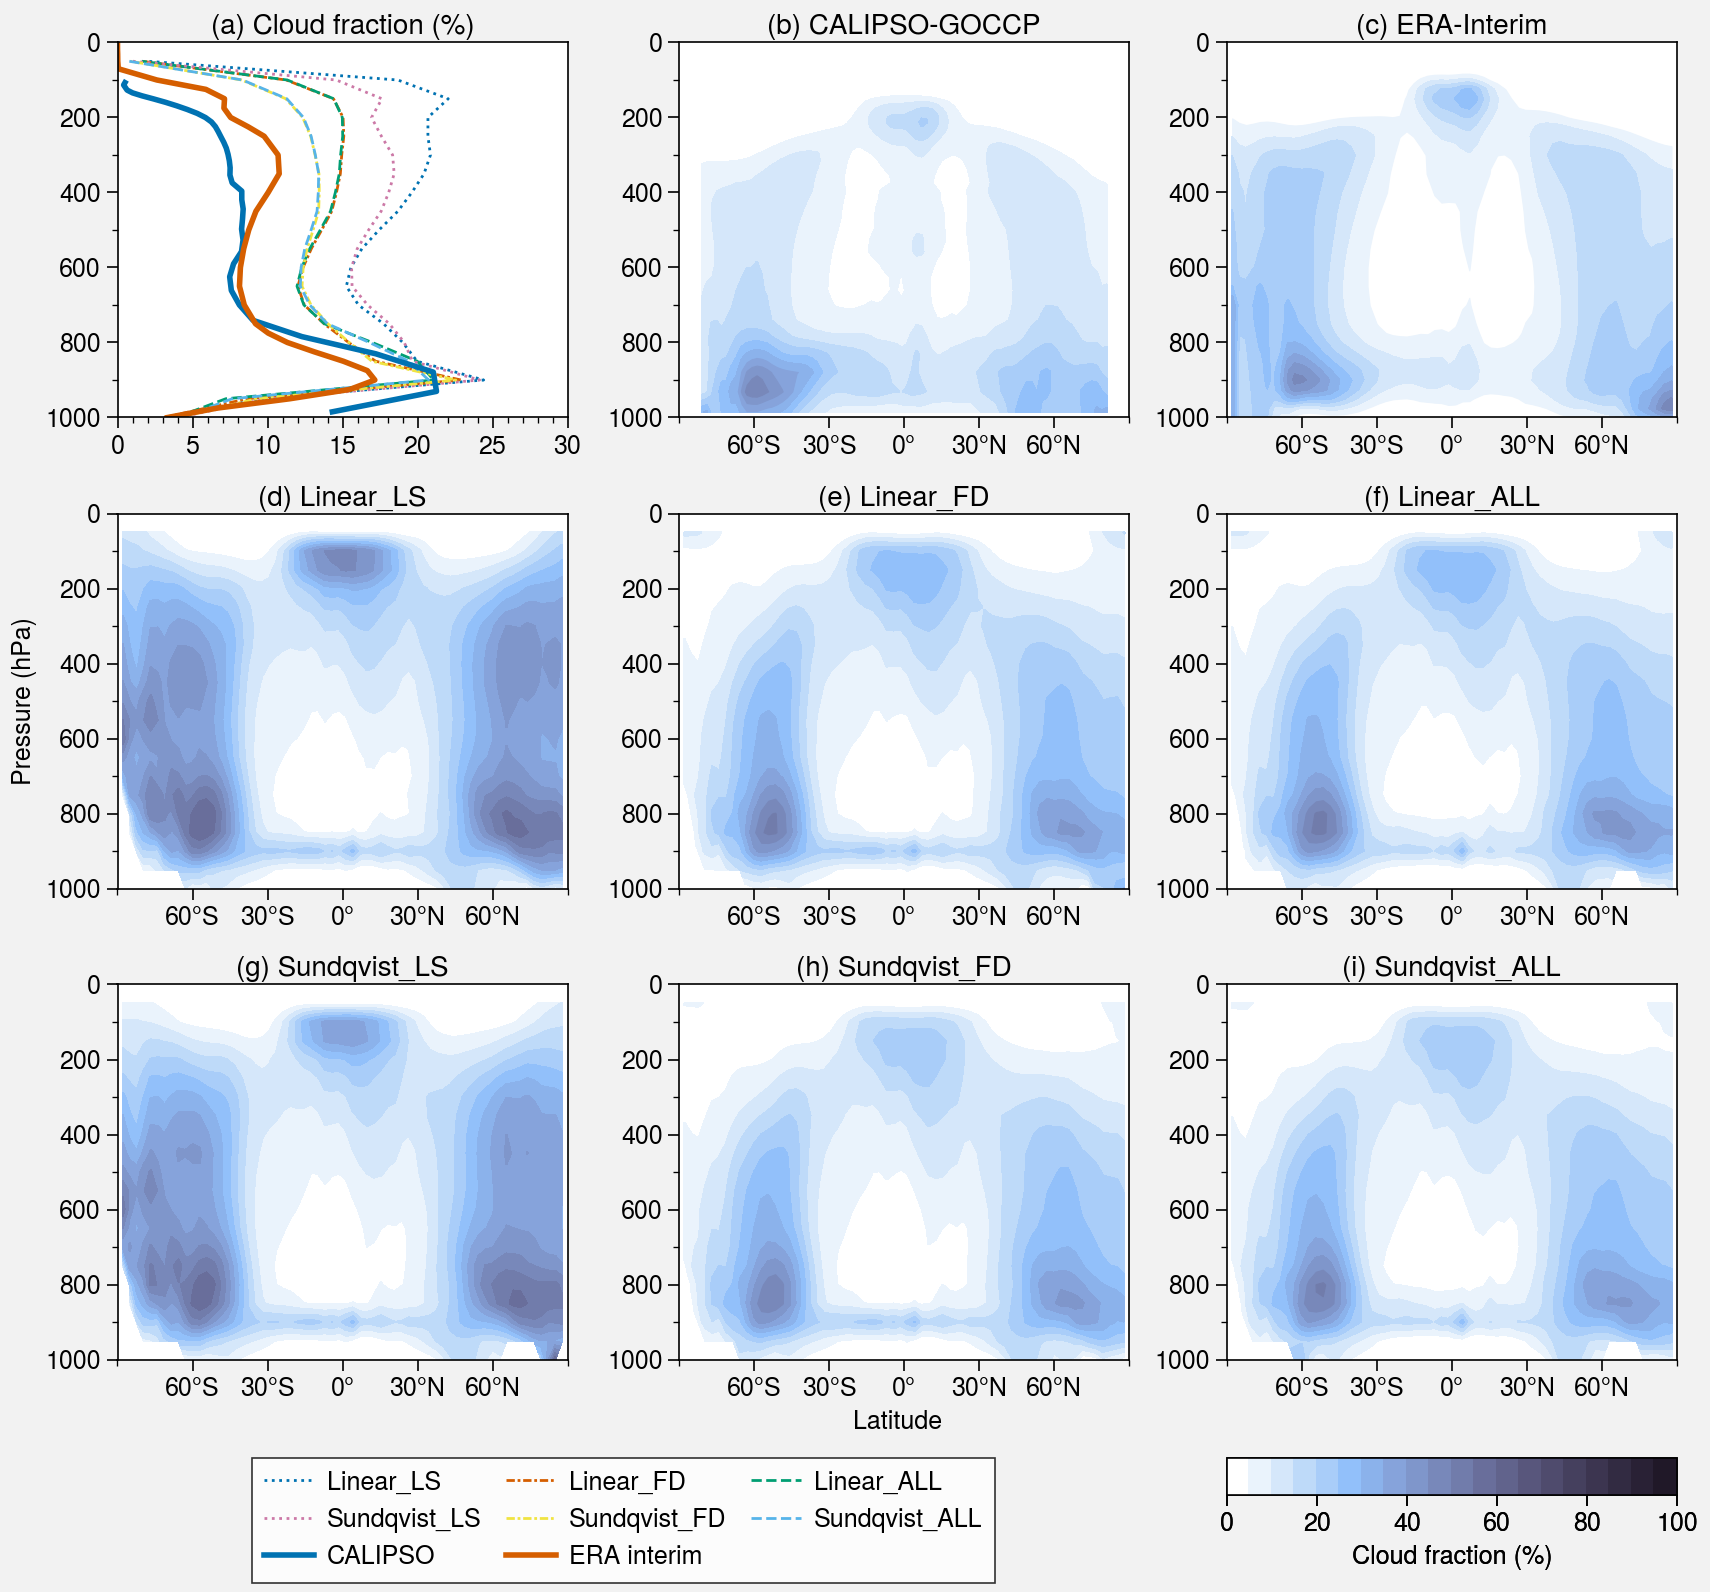

In [11]:
# ================== Fig. 6 zonal mean profiles of cloud fractions  ================== # 

# https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html
line_styles = [':', (0, (3, 1, 1, 1)), '--', ':', (0, (3, 1, 1, 1)), '--']

# plot zonal mean cloud fraciton profile
print('plot zonal mean cloud fraciton profile...')
fig_name = P(fig_dir, 'cloud_zonal_mean_vert_profiles.pdf')
zonal_mean_cld_frac_vertical_profile(ds_lev_arr, exp_names, line_styles, figname=fig_name)

## Fig. 7 Geographical pattern of low cloud amount

In [12]:
# =============== Self-defined colormap  =============== #
bottom = cm.get_cmap('RdBu_r', 128)
top = cm.get_cmap('RdBu_r', 128)
newcolors = np.vstack((bottom(np.linspace(0.1, 0.5, 12)),
                    np.array([1.0, 1.0, 1.0, 1.0]),
                    top(np.linspace(0.5, 0.9, 12))))
BuWhRd = ListedColormap(newcolors, name='BuWhRd')


# =============== Self-defined colormap  =============== #
N = 11
a = cm.get_cmap(cmaps.CBR_wet, N)
b = np.ones((2*N-1, 4))
for i in range(N-1):
    b[2*i,:] = np.array(a(i))
    b[2*i+1,:] = (np.array(a(i)) + np.array(a(i+1))) / 2
b[-1,:] = np.array(a(N-1)) #a(N-1)
newcolors = np.vstack((b))
CBR_wet_21lev = ListedColormap(newcolors, name='CBR_wet_21lev')

Plot spatial patterns
low_cld_amt


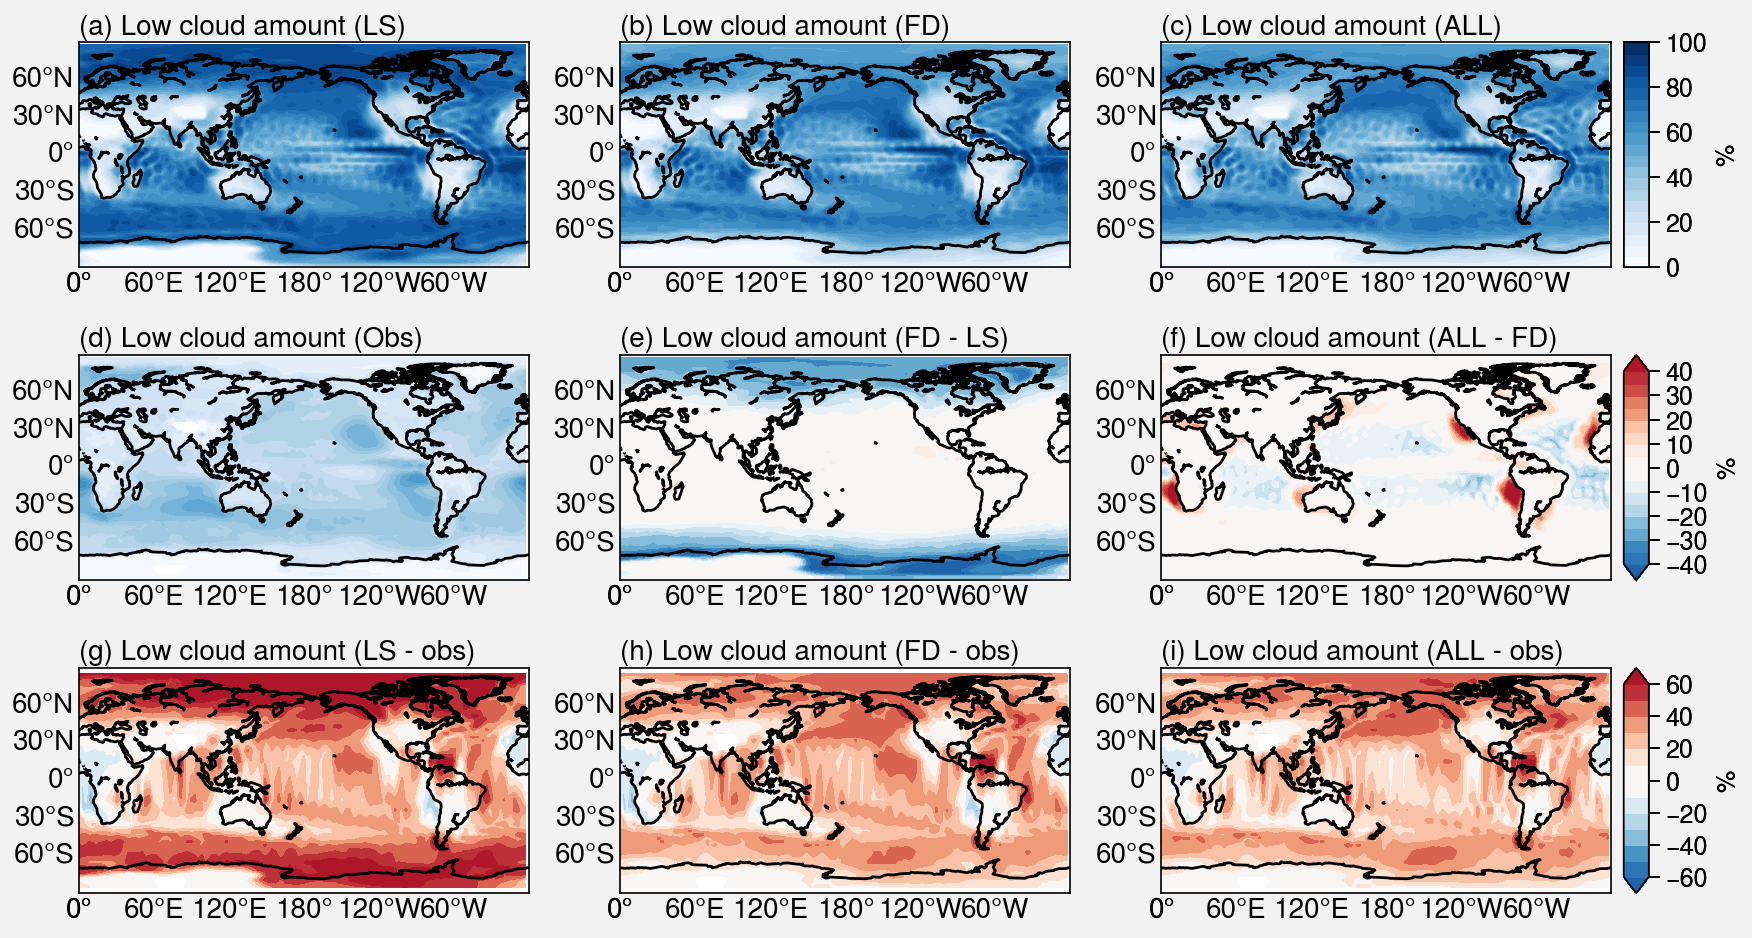

In [13]:
ds_arr_spatial = [ds_lev_arr[0], ds_lev_arr[1], ds_lev_arr[2]]
diff_colormap = BuWhRd       # cmaps.BlueWhiteOrangeRed # 'RdBu_r' #
cld_cmap1 = cmaps.MPL_Blues  # CBR_wet_21lev #cmaps.CBR_wet #cmaps.precip_11lev # #cmaps.amwg # cmaps.MPL_Blues
l_title_add_gm = False

print('Plot spatial patterns')

'''
# cmp tot_cld_amt
var_name = 'tot_cld_amt'
print(var_name)
fig_name = P(fig_dir, 'tot_cld_amt_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_cf_dict, var_name, fig_name,
                obs_name='Obs', title_nm='Total cldamt', 
                cmap1=cld_cmap1, cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

# cmp high_cld_amt
var_name = 'high_cld_amt'
print(var_name)
fig_name = P(fig_dir, 'high_cld_amt_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_cf_dict, var_name, fig_name, 
                obs_name='Obs', title_nm='High cldamt', 
                cmap1=cld_cmap1, cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

# cmp mid_cld_amt
var_name = 'mid_cld_amt'
print(var_name)
fig_name = P(fig_dir, 'mid_cld_amt_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_cf_dict, var_name, fig_name, 
                obs_name='Obs', title_nm='Middle cldamt', 
                cmap1=cld_cmap1, cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)
                #cmap1=, cmap2=diff_colormap)
'''

# cmp low_cld_amt
var_name = 'low_cld_amt'
print(var_name)
fig_name = P(fig_dir, 'low_cld_amt_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_cf_dict, var_name, fig_name, 
                obs_name='Obs', title_nm='Low cldamt',
                cmap1=cld_cmap1, cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

## Fig. 8 Cloud amount seasonal cycyle in Arctic region

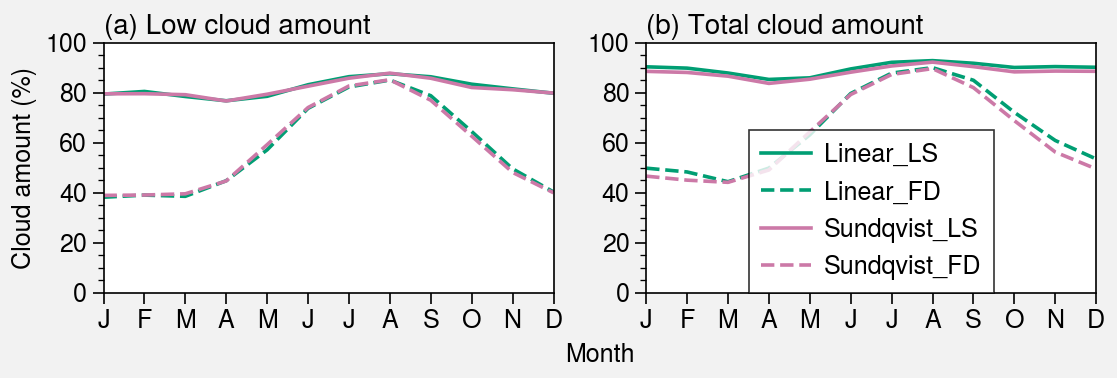

In [14]:
fig_name = P(fig_dir, 'cloud_amount_in_arctic_region.pdf')
# Linear_LS, Linear_FD, Sundqvist_LS, Sundqvist_FD
index = [0, 1, 3, 4]
ds_arr_local = [ds_lev_arr[i] for i in index]
exp_names_local = [exp_names[i] for i in index]
#line_styles_local = [line_styles[i] for i in index]
polar_cloud_amount_seasonal_cycle(ds_arr_local, exp_names_local, fig_name) # obs_cf_dict,

## Fig. 9 CWP

cwp


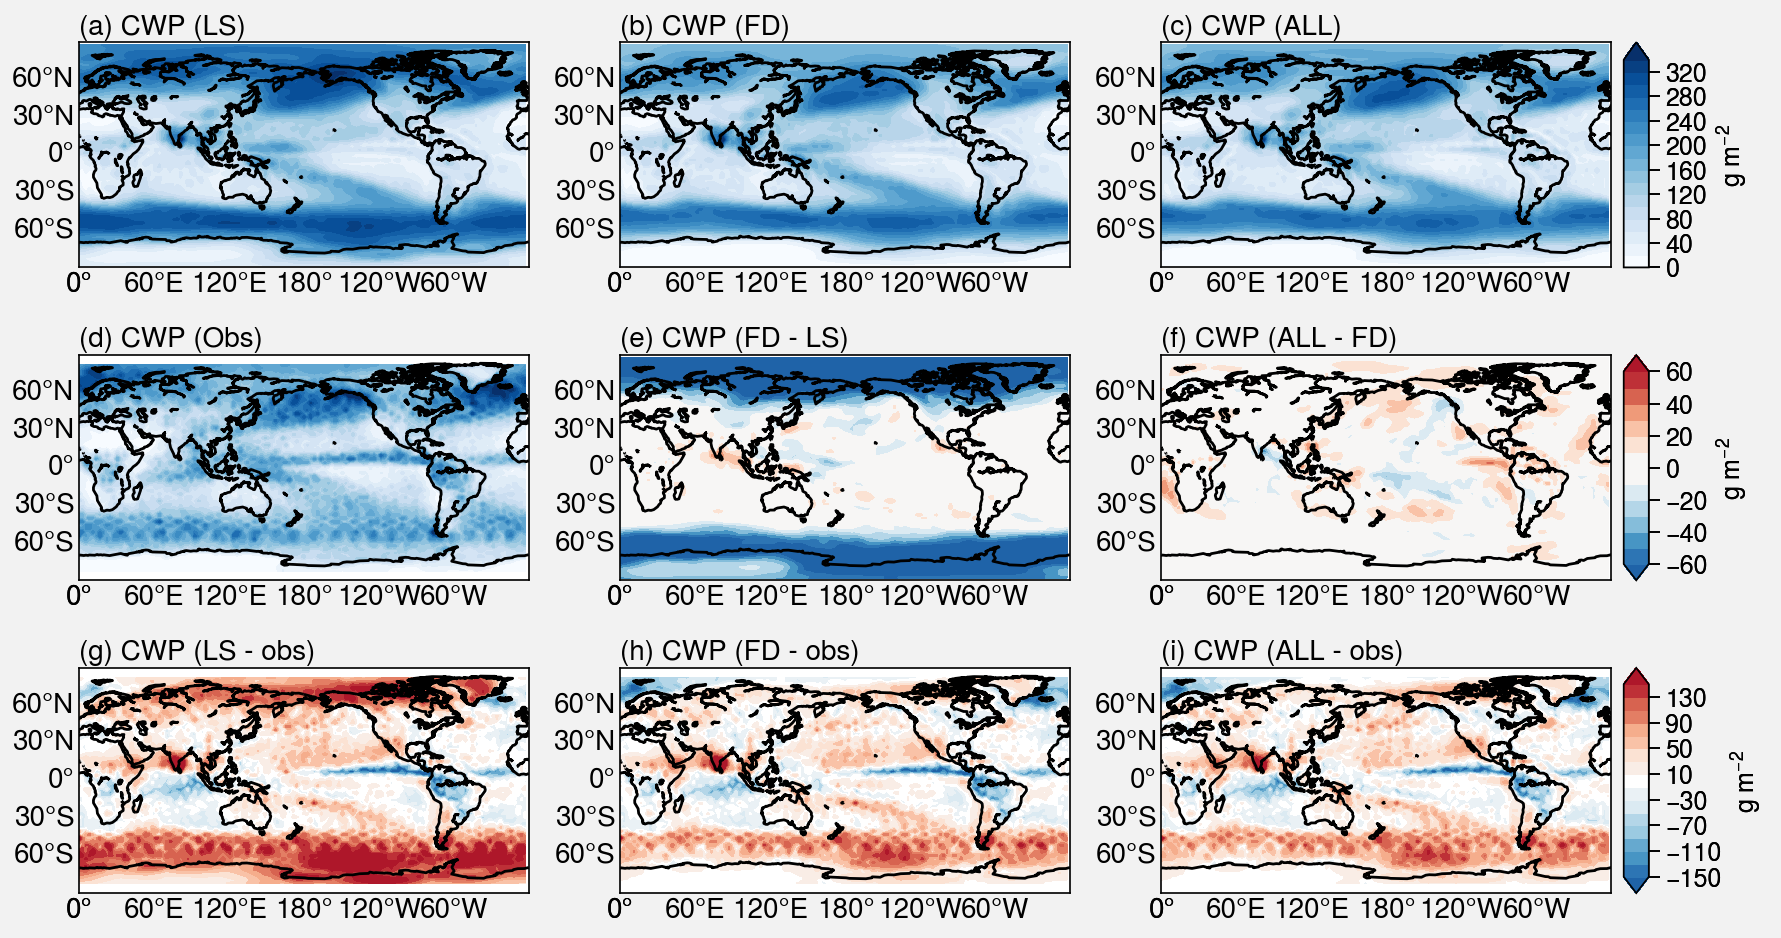

In [15]:
# Cloud water path
var_name = 'cwp'
print(var_name)
fig_name = P(fig_dir, 'cwp_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='CWP', 
                cmap1='Blues', cmap2=diff_colormap, coeff=1.0e3, l_title_add_gm=l_title_add_gm)

## Fig. 10 SW CRE

toa_sw_cre


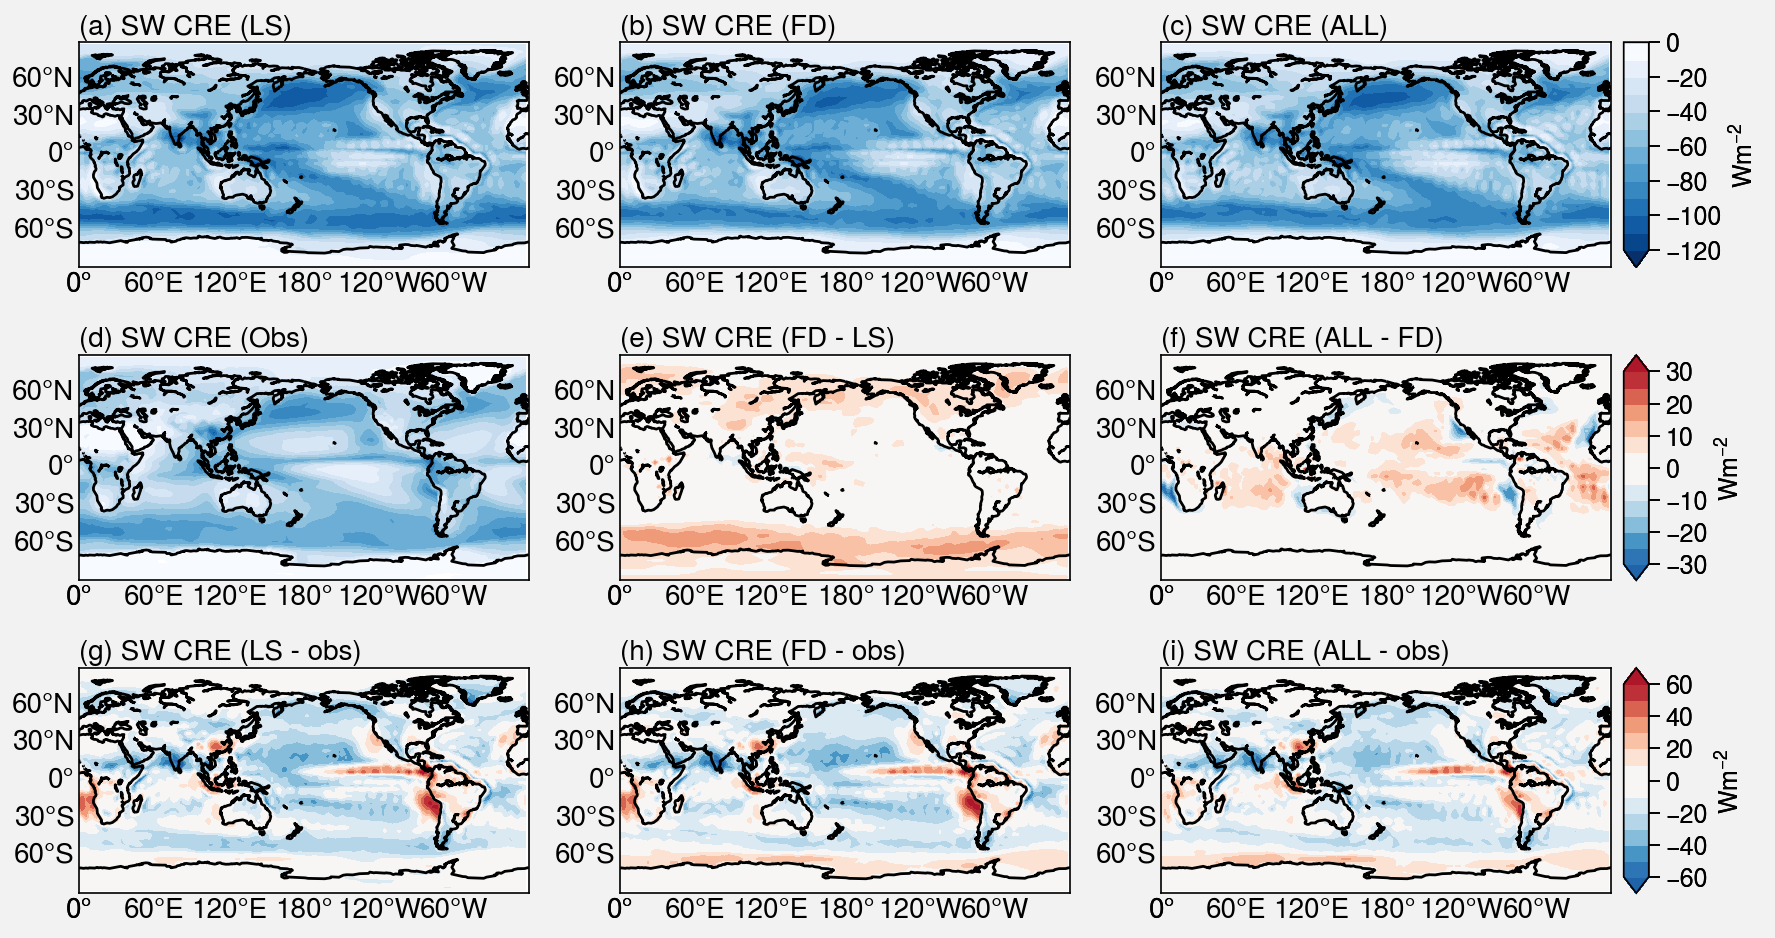

In [16]:
## ======== Flux  ======== ##
'''
# cmp reflected SW flux
var_name = 'toa_sw_up'
print(var_name)
fig_name = P(fig_dir, 'toa_sw_up_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='Reflected SW', 
                cmap1='Oranges', cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

# cmp OLR
var_name = 'olr'
fig_name = P(fig_dir, 'toa_olr_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='OLR', 
                cmap1='Oranges', cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

# cmp net flux
var_name = 'toa_net_flux'
print(var_name)
fig_name = P(fig_dir, 'toa_net_flux_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='Net flux', 
                cmap1='RdBu_r', cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)
'''

## ======== CRE  ======== ##
var_name = 'toa_sw_cre'
print(var_name)
fig_name = P(fig_dir, 'toa_sw_cre_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='SW CRE', 
                cmap1='Blues_r', cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

## Fig. 11  Low cloud improvement

Low cloud improvement evaluation...


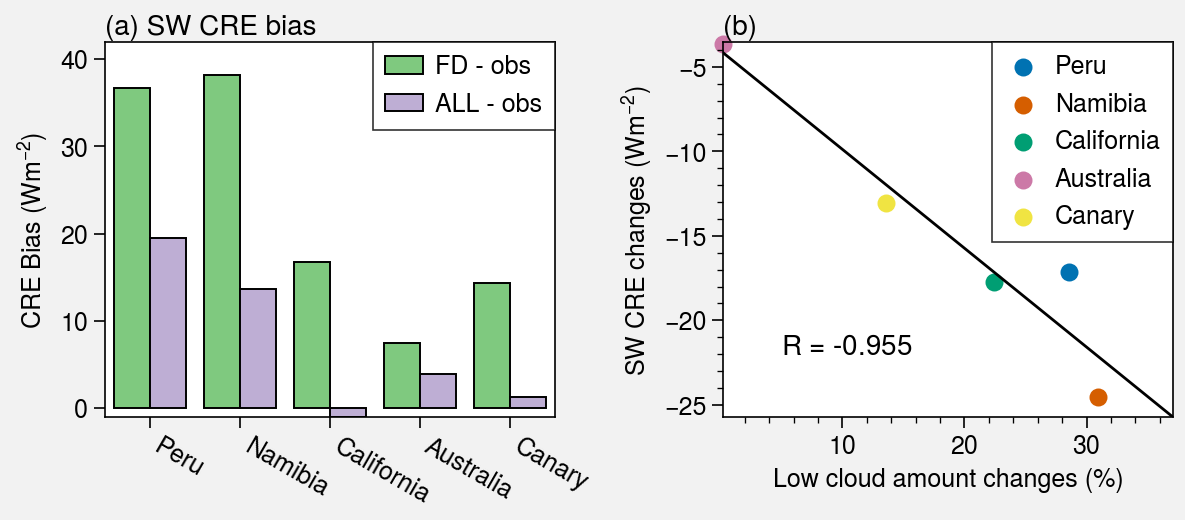

In [17]:
print('Low cloud improvement evaluation...')
ds_arr_low = [ds_lev_arr_linear[1], ds_lev_arr_linear[2]]
exp_names_local = [exp_names[1], exp_names[2]]

fig_name = P(fig_dir, 'SW_CREs_improvement_linear.pdf')
low_cloud_improvement_evaluation(ds_arr_low, exp_names_local, obs_flux_dict, fig_name)

## Fig. 12 LW CRE

toa_lw_cre


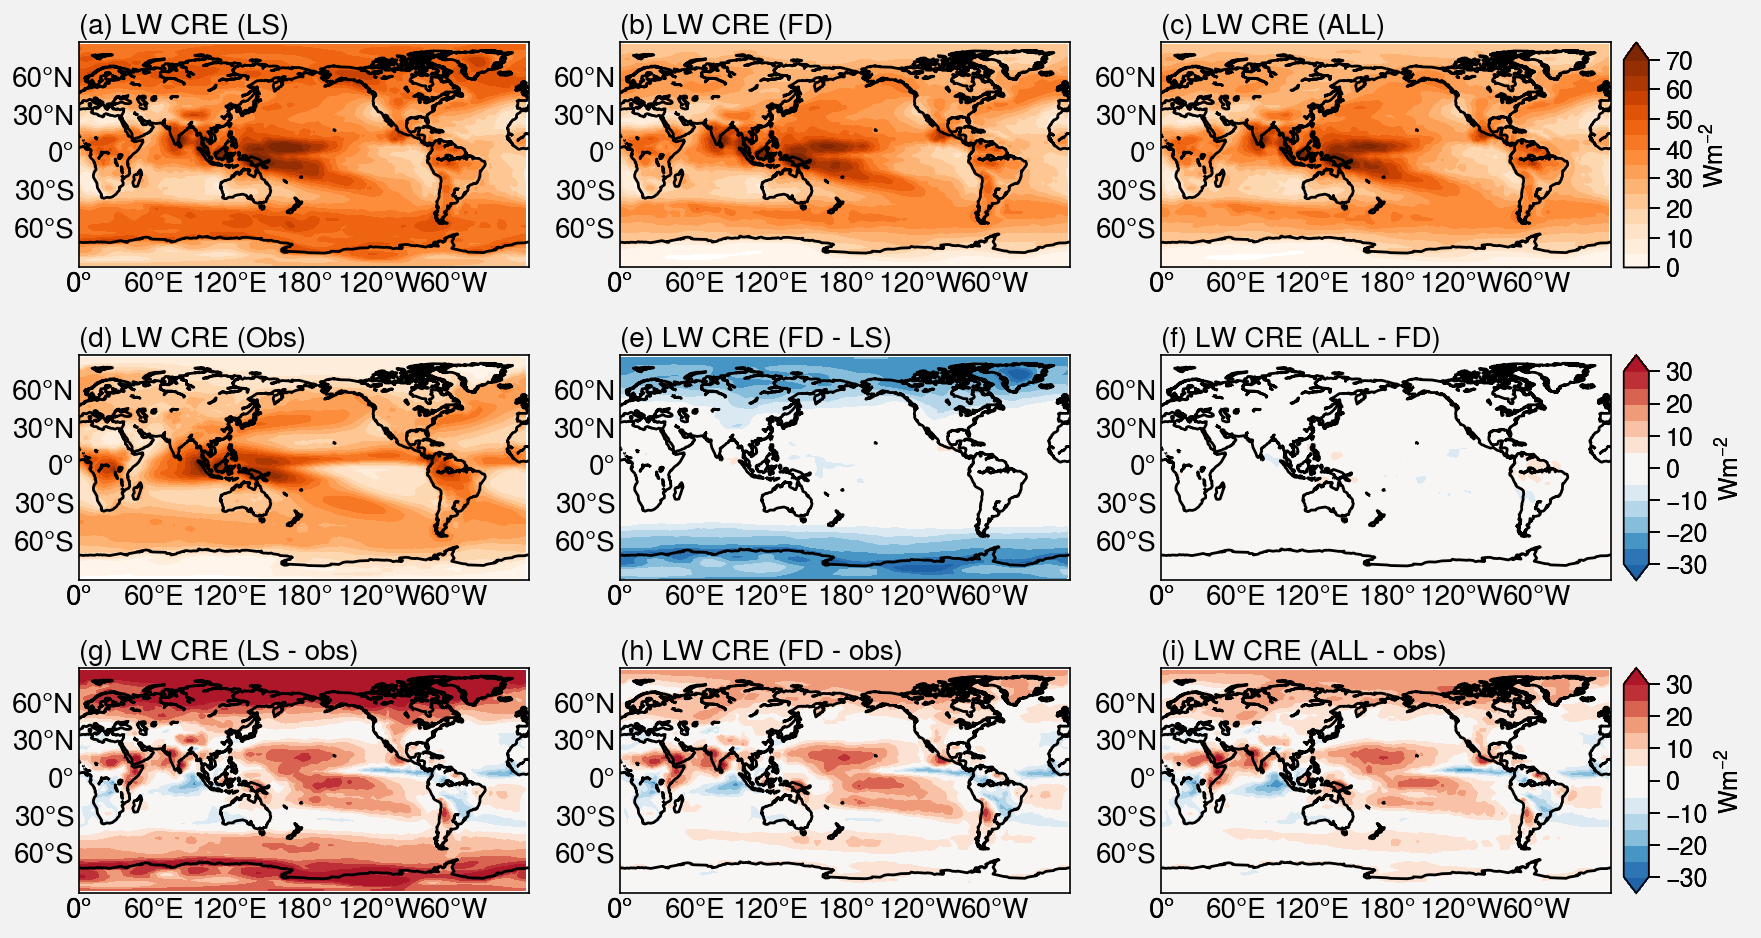

In [18]:
var_name = 'toa_lw_cre'
print(var_name)
fig_name = P(fig_dir, 'toa_lw_cre_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='LW CRE', 
                cmap1='Oranges', cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

## Fig. 13 LW CRE improvement

In [19]:
# ======== bin dataset according to omega500 =========== #

ds_lev_arr_local = [x for x in ds_lev_arr_linear]
exp_names_local = [x for x in exp_names[0:3]]
land_sea_mask = 'ocean'
grp_time = 'year'
s_lat = -30
n_lat = 30

# omega500 bins
bin_nm = 'omega500'
bins = np.arange(-100, 101, 5)

print('bin data according to ' + bin_nm + '...')

# =========================== Observation ============================= #
# start_year = 2005
# end_year = 2014

# ============ Read ERAI omega data ============ #
print('Vertical velocity omega from ERAI...')
fnm_omega = P(obs_base_dir, 'ecmwf_data', 'ecmwf_omega_1979_2017_t42.nc')
ds_w = xr.open_dataset(fnm_omega, decode_times=False)
add_datetime_info(ds_w)
l_yr = np.logical_and(ds_w.year>=start_year, ds_w.year<=end_year)
omega = ds_w.w.where(l_yr, drop=True)   # Pa/s

omega_coeff = 3600. * 24. / 100.
omega500 = omega.sel(level=500) * omega_coeff

lats = omega500.lat
lons = omega500.lon
times = omega500.time

# ================== CRE ================== #
print('CRE data from CERES_EBAF...')
file_nm = 'CERES_EBAF-TOA_Ed4.1_Subset_200101-201812_t42.nc'
ds_cre = xr.open_dataset(P(obs_base_dir, 'CERES', file_nm), decode_times=False)
add_datetime_info(ds_cre)

l_yr_cre = np.logical_and(ds_cre.year>=start_year, ds_cre.year<=end_year)
cre_dt = {}
cre_dt['toa_sw_cre'] = (ds_cre.toa_sw_clr_c_mon - ds_cre.toa_sw_all_mon).where(l_yr_cre, drop=True)
cre_dt['toa_lw_cre'] = (ds_cre.toa_lw_clr_c_mon - ds_cre.toa_lw_all_mon).where(l_yr_cre, drop=True)
cre_dt['toa_net_cre'] = cre_dt['toa_sw_cre'] + cre_dt['toa_lw_cre']

# construct the dataset
dims = ('time', 'lat', 'lon')
ds_obs = xr.Dataset({ 'omega500': (dims, np.array(omega500)), 
            'toa_sw_cre': (dims, np.array(cre_dt['toa_sw_cre'])),
            'toa_lw_cre': (dims, np.array(cre_dt['toa_lw_cre'])),
            'toa_net_cre': (dims,np.array(cre_dt['toa_net_cre'])),
            'low_cld_amt': (dims, np.array(obs_cf_dict['low_cld_amt'])),
            'mid_cld_amt': (dims, np.array(obs_cf_dict['mid_cld_amt'])),
            'high_cld_amt': (dims, np.array(obs_cf_dict['high_cld_amt'])),
            'tot_cld_amt': (dims, np.array(obs_cf_dict['tot_cld_amt']))},
            coords={'time': times, 'lat': omega500.lat, 'lon': lons})

add_datetime_info(ds_obs)

ds_bin = bin_obs_data(ds_obs, s_lat=s_lat, n_lat=n_lat, 
            grp_time_var=grp_time, bin_var_nm=bin_nm,
            bins=bins, land_sea=land_sea_mask)
# use filter to remove the empty string
# refer to: https://stackoverflow.com/questions/8626694/joining-multiple-strings-if-they-are-not-empty-in-python
dt_fn = '_'.join(filter(None, ['ds_obs_bin', bin_nm, grp_time, land_sea_mask]))
ds_bin.to_netcdf(P(save_dt_dir, dt_fn+'.nc'), mode='w', format='NETCDF3_CLASSIC')
print(dt_fn + '.nc saved.')

# =========================== Isca ============================= #
file_ids = [x for x in exp_names_local]
for ds, file_id in zip(ds_lev_arr_local, file_ids):
    ds_bin = bin_isca_exp_data(ds, s_lat=s_lat, n_lat=n_lat, 
                grp_time_var=grp_time, bin_var_nm=bin_nm, bin_var=None,
                bins=bins, land_sea=land_sea_mask)
    
    dt_fn = '_'.join(filter(None, ['ds_bin', bin_nm, file_id, grp_time, land_sea_mask]))
    ds_bin.to_netcdf(P(save_dt_dir, dt_fn+'.nc'), mode='w', format='NETCDF3_CLASSIC')
    print(dt_fn + '.nc saved.')

bin data according to omega500...
Vertical velocity omega from ERAI...
CRE data from CERES_EBAF...
ds_obs_bin_omega500_year_ocean.nc saved.
ds_bin_omega500_Linear_LS_year_ocean.nc saved.
ds_bin_omega500_Linear_FD_year_ocean.nc saved.
ds_bin_omega500_Linear_ALL_year_ocean.nc saved.


plot omega500...
plot lines...


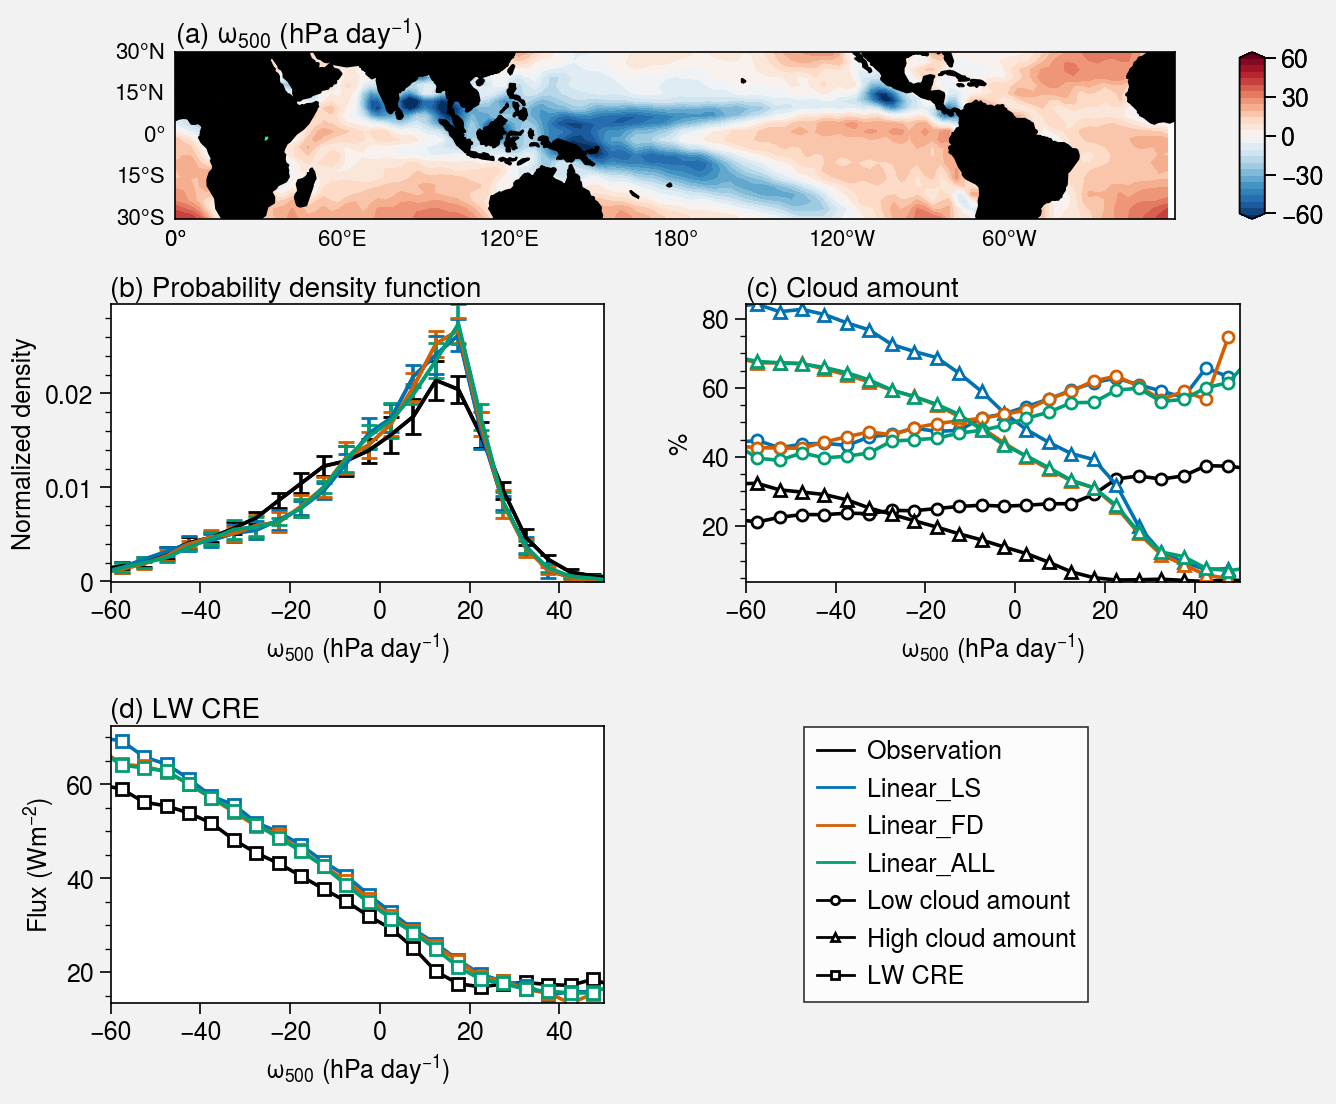

In [20]:
titles = ['Probability density function', 'Cloud amount', 'LW CRE'] #, 'Middle cloud amount', 'High cloud amount']
ylabels = ['Normalized density', r'%', r'Flux (Wm$^{-2}$)'] #, r'Cloud amount (%)', r'Cloud amount (%)',]

dt_arrs = []
labels = ['Observation']

# produce obs bin data....
ds_bin = xr.open_dataset(P(save_dt_dir, 'ds_obs_bin_omega500_' + str(grp_time) + '_' 
                           + str(land_sea_mask)+'.nc'), decode_times=False)
dt_arr_obs = [ds_bin.pdf_omega, ds_bin.low_cld_amt, ds_bin.high_cld_amt, ds_bin.toa_lw_cre]
dt_arrs.append(dt_arr_obs)

# ================= ISCA data =============== #
for exp_nm in exp_names_local:
    ds_bin = xr.open_dataset(P(save_dt_dir, 'ds_bin_omega500_' + exp_nm + '_' + str(grp_time) + '_' 
                               + str(land_sea_mask) + '.nc'), decode_times=False)
    dt_arr_isca = [ds_bin.pdf_omega, ds_bin.low_cld_amt, ds_bin.high_cld_amt, ds_bin.toa_lw_cre]
    dt_arrs.append(dt_arr_isca)
    labels.append(exp_nm)

i_colors = ['k', 'C0', 'C1', 'C2']

fig_name = P(fig_dir, 'linear_cldamt_lwcre_binned_by_omega_' + grp_time + '_' + str(land_sea_mask) + '.pdf')
cld_amt_and_lw_cre_composite_analysis_omega500(ds_lev_arr_linear[0], dt_arrs, labels, i_colors, titles, ylabels,
         fig_name, nrows=2, ncols=2, bins=bins, capsize=3)

## Fig. 14 Net CRE

toa_net_cre


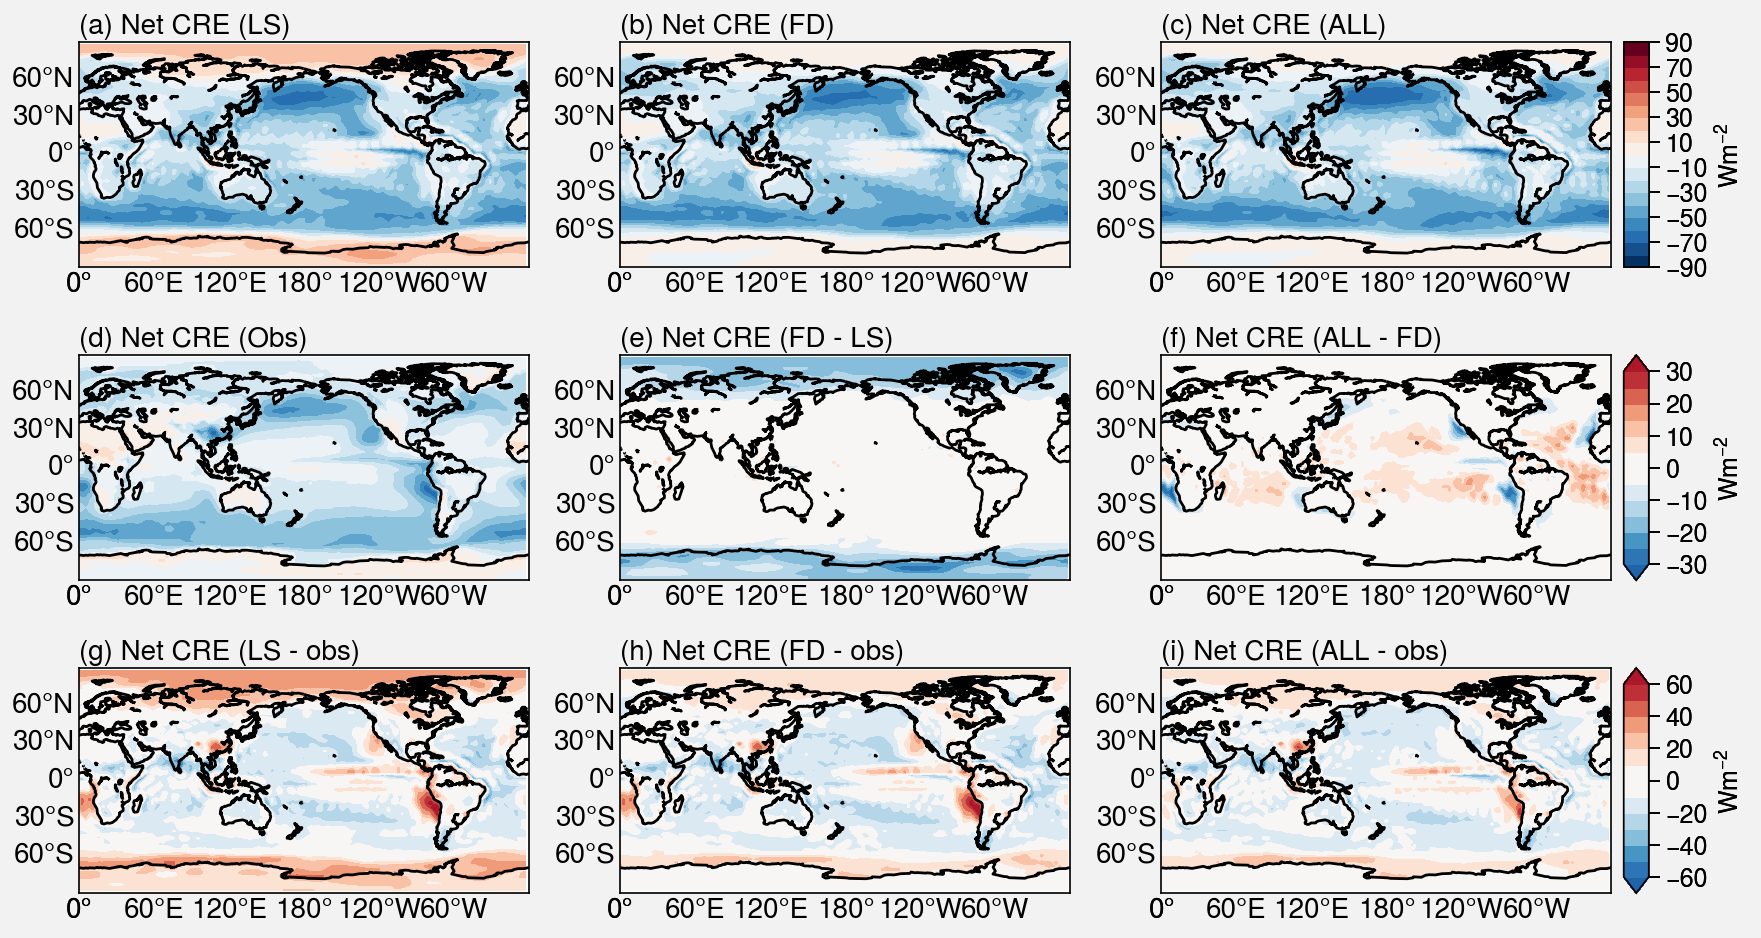

In [21]:
var_name = 'toa_net_cre'
print(var_name)
fig_name = P(fig_dir, 'toa_net_cre_isca_obs.pdf')
cmp_spatial_patterns_from_exps_and_obs(ds_arr_spatial, obs_flux_dict, var_name, fig_name,
                obs_name='Obs', title_nm='Net CRE', 
                cmap1='RdBu_r', cmap2=diff_colormap, l_title_add_gm=l_title_add_gm)

## Fig. 15 Zonal mean CREs

Read CRE from CMIP5 models...
Zonal mean TOA CRE analysis...


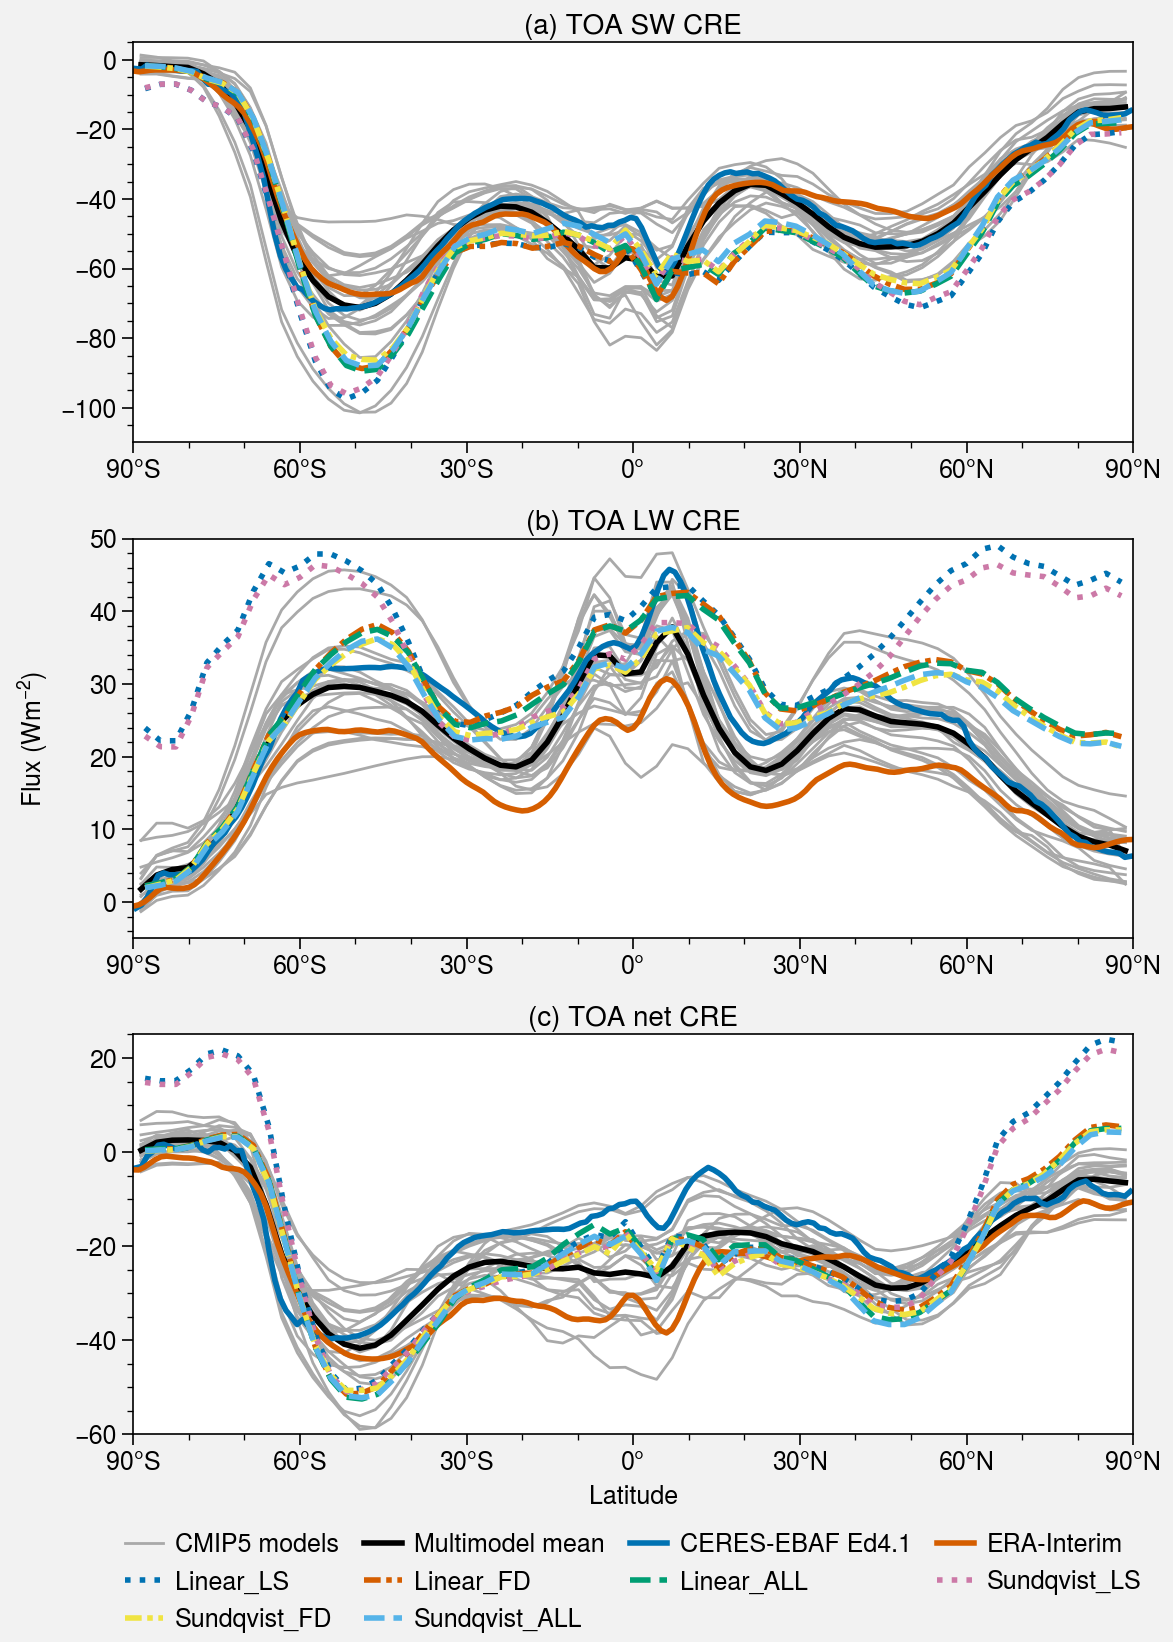

In [22]:
print('Read CRE from CMIP5 models...')
cmip5_zm_cre = np.load(P(save_dt_dir, 'cmip5_historical_zm_cre_r128x64.npy'), allow_pickle=True).item()

zonal_obs_names = [obs_nm, 'ERA-Interim']

print('Zonal mean TOA CRE analysis...')
fig_name = os.path.join(fig_dir, 'cmp_zonal_toa_CRE_cmip_isca.pdf')
cmp_zonal_mean_CREs(ds_lev_arr, exp_names, obs_toa_cre, fig_name, 
                cmip_dict=cmip5_zm_cre, line_styles=line_styles, obs_names=zonal_obs_names)

## Fig. 16  Seasonal cycle of CREs

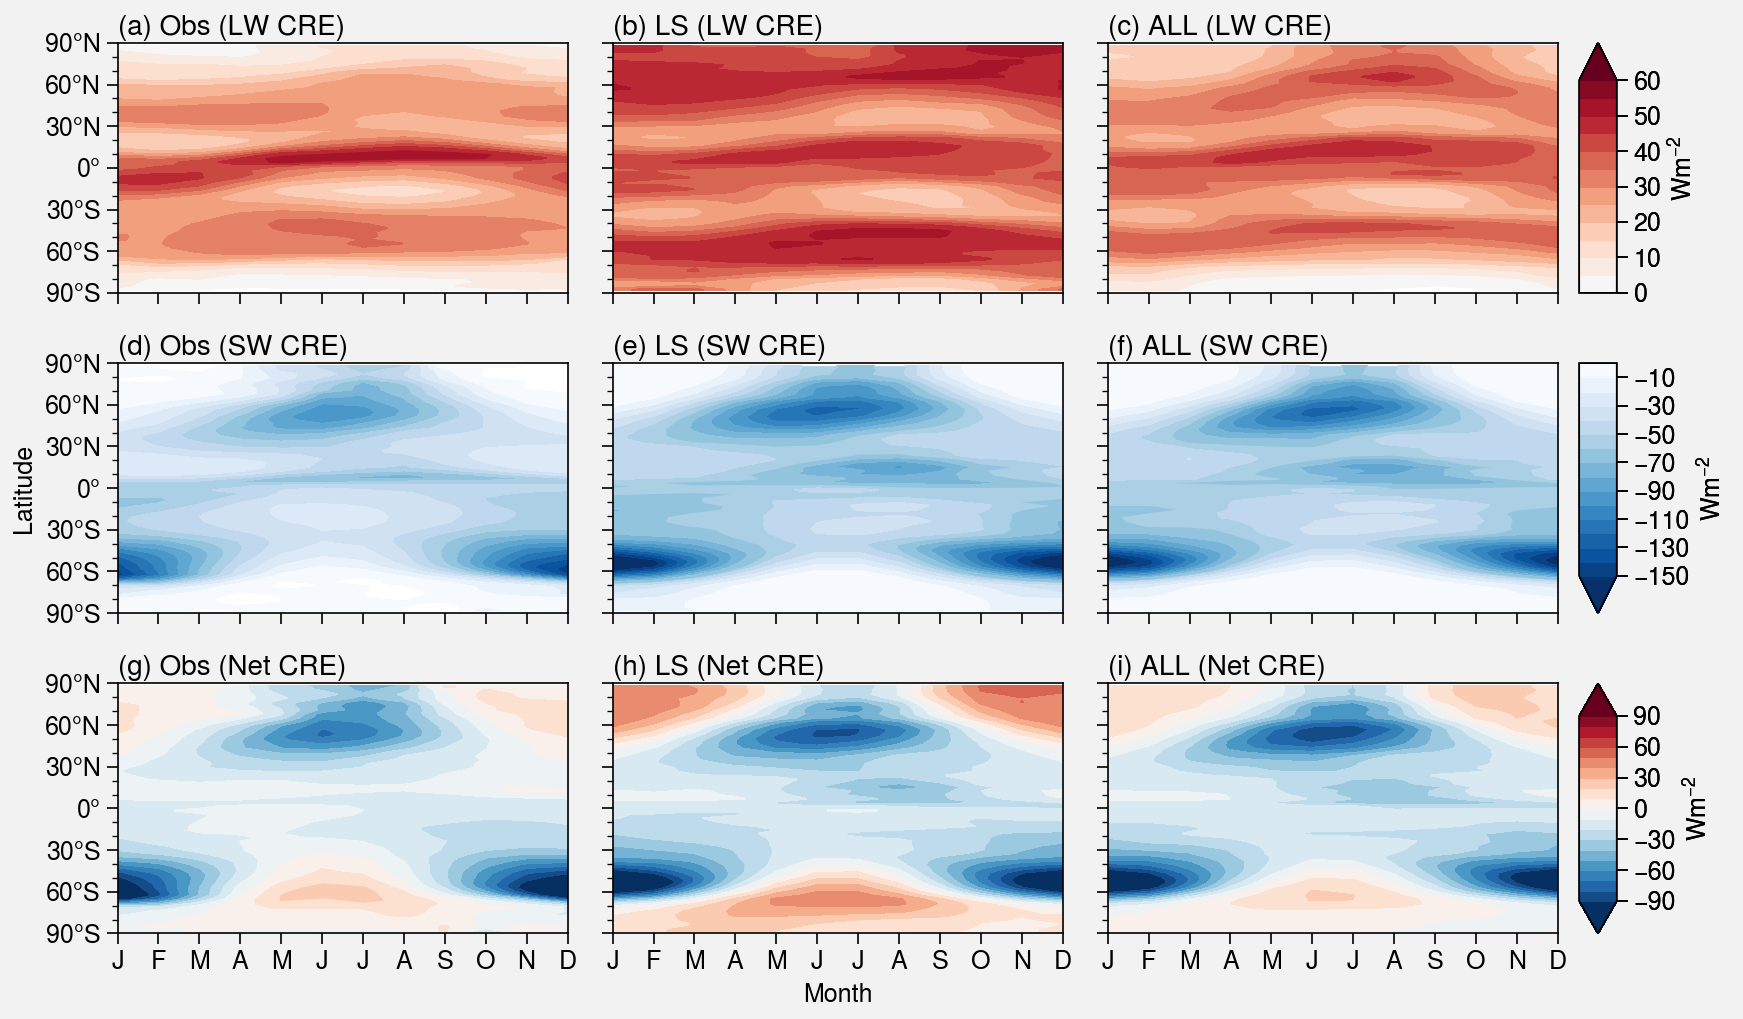

In [23]:
fig_name = P(fig_dir, 'isca_linear_amip_seasonal_cycle_map.pdf')
cre_seasonal_cycle(obs_flux_dict, [ds_lev_arr[0], ds_lev_arr[2]], ['LS', 'ALL'], fig_name)

## Fig. 17  Global mean bar plot

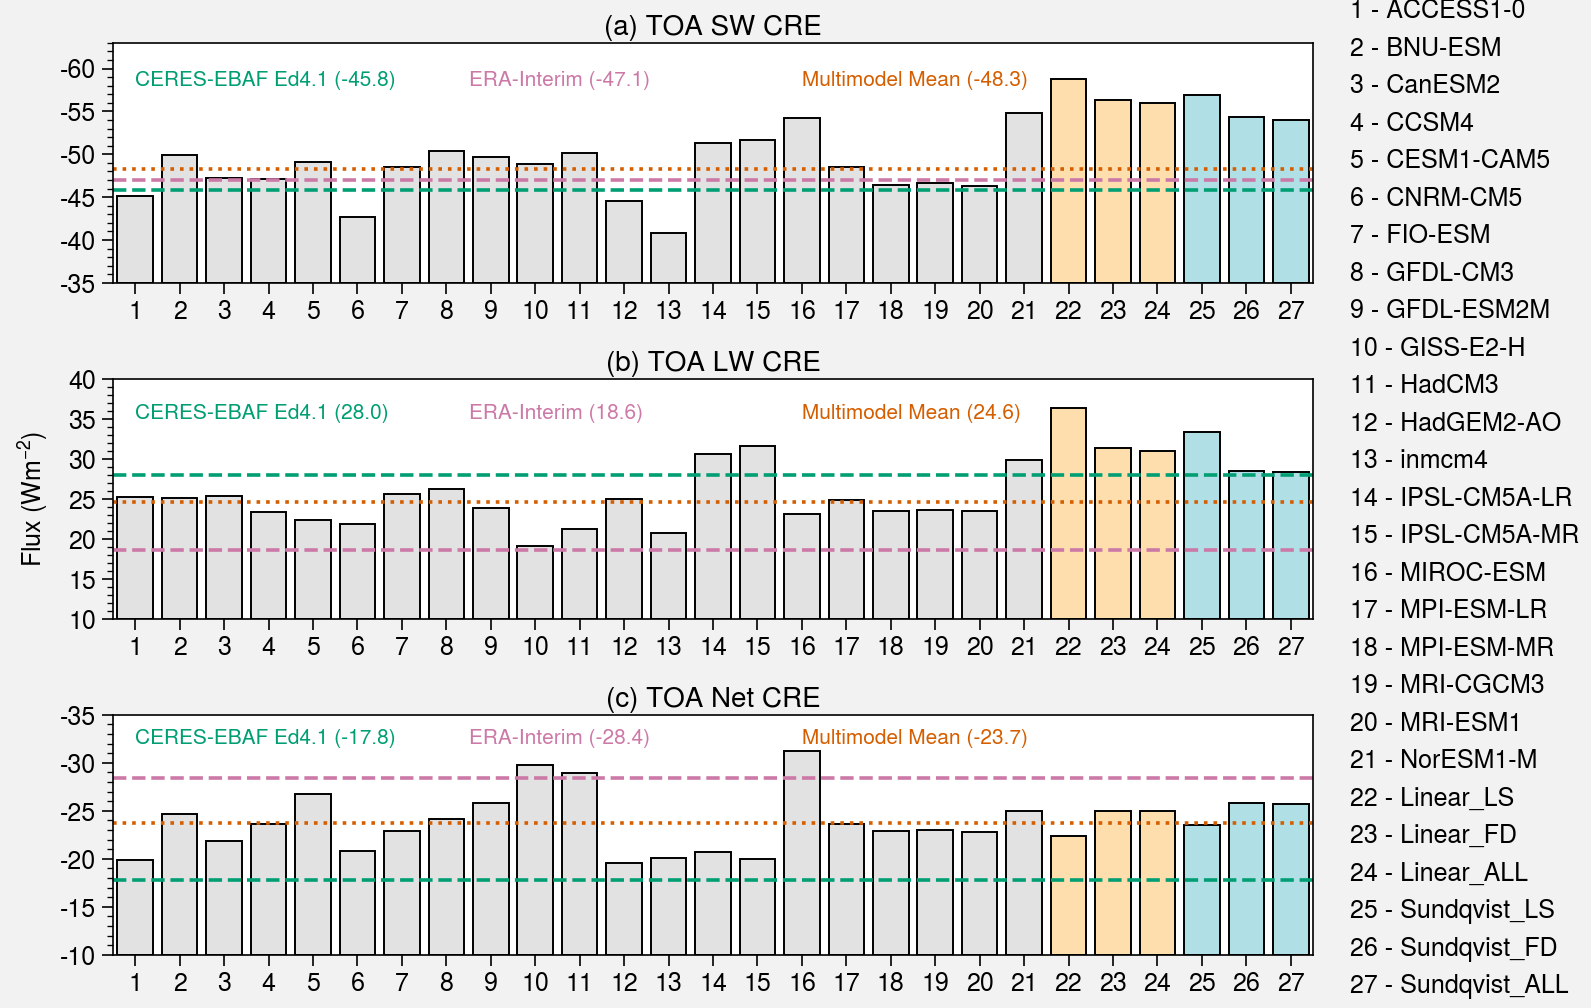

In [24]:
fig_name = P(fig_dir, 'global_mean_toa_CREs_4.1.pdf')
global_mean_CRE_bar_plot(ds_lev_arr, exp_names, obs_toa_cre, fig_name)

## Fig. 18  Taylor diagram

./taylor_data/taylor_cmip5_isca_lwcre.txt saved.
./taylor_data/taylor_cmip5_isca_swcre.txt saved.
./taylor_data/taylor_cmip5_isca_netcre.txt saved.
plot taylor diagram...


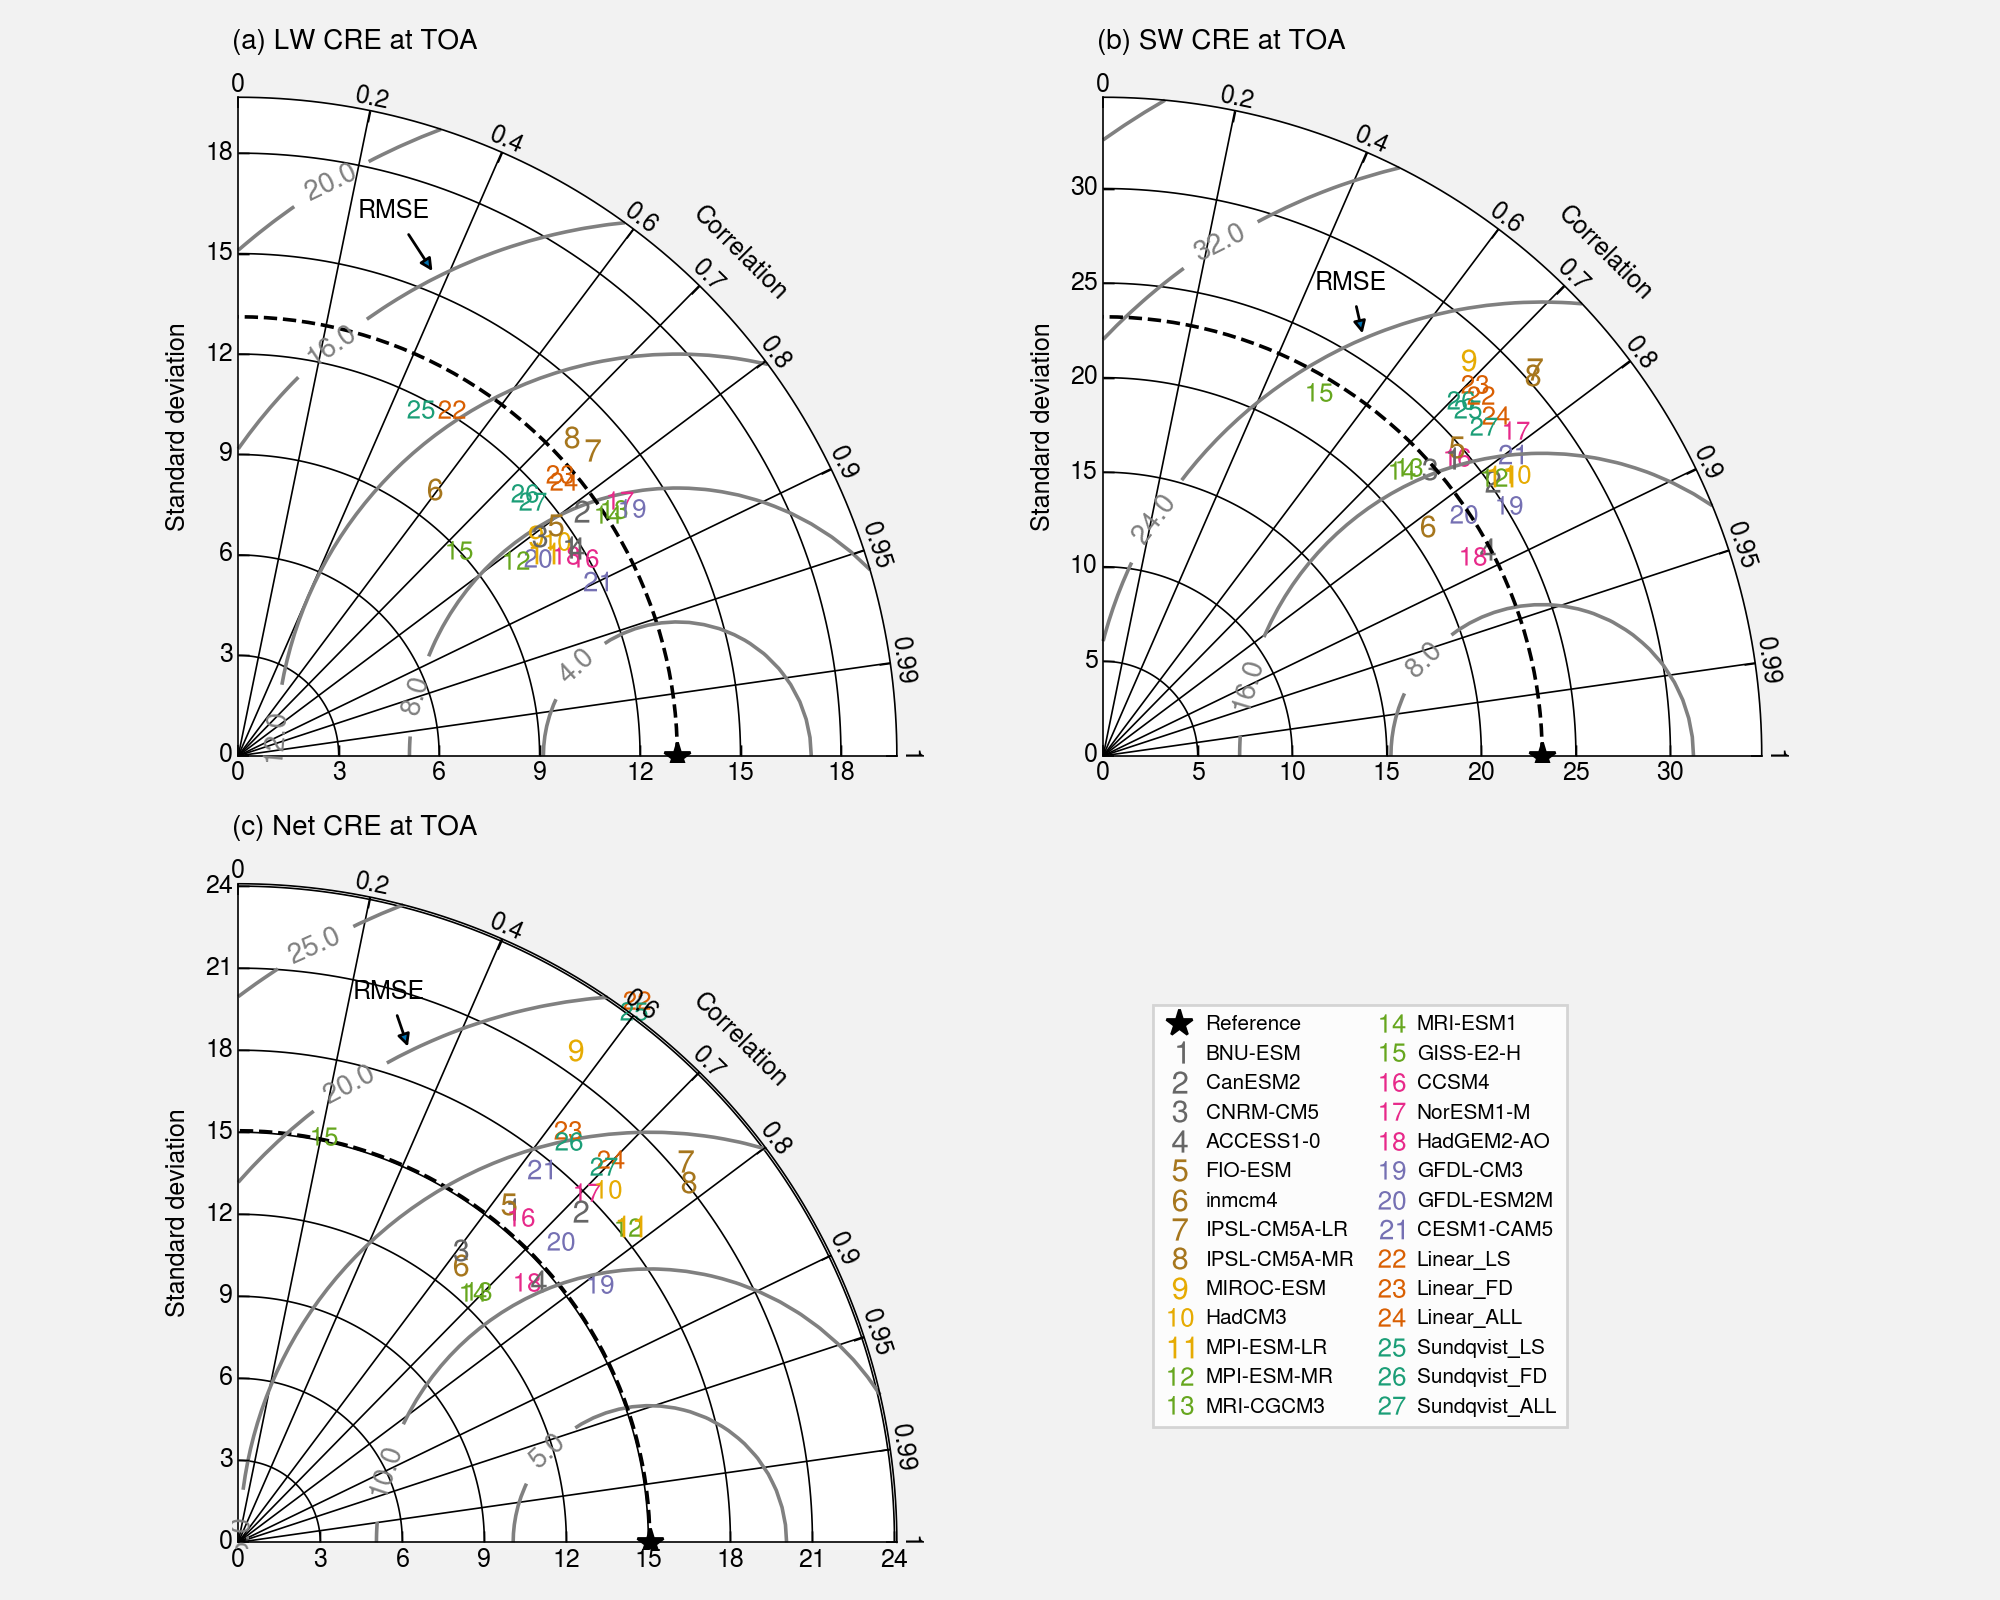

In [25]:
taylor_dir = './taylor_data'
if not os.path.exists(taylor_dir):
    os.mkdir(taylor_dir)

lwcre_taylor_fn = P(taylor_dir, 'taylor_cmip5_isca_lwcre.txt')
swcre_taylor_fn = P(taylor_dir, 'taylor_cmip5_isca_swcre.txt')
netcre_taylor_fn = P(taylor_dir, 'taylor_cmip5_isca_netcre.txt')

write_taylor_diagram_stats(ds_lev_arr, exp_names, obs_flux_dict,
                            out_lwcre_fn=lwcre_taylor_fn,
                            out_swcre_fn=swcre_taylor_fn, 
                            out_netcre_fn=netcre_taylor_fn)

# plot taylor diagram
print('plot taylor diagram...')
fig_name = os.path.join(fig_dir, 'cmp_cmip5_isca_CRE_taylor_obs_v4.1_sundqvist_linear.pdf')
plot_taylor_diagram(lwcre_taylor_fn, swcre_taylor_fn, netcre_taylor_fn, figname=fig_name)